In [38]:
# Potrebno za Google Colab
# Odkomentarisati komande ispod pre prvog pokretanja, a zatim ponovo zakomentarisati

#! git clone https://github.com/AAnzel/Master_rad.git
#! mkdir ../data
#! mv Master_rad/data/UniProt\ cist ../data/


fatal: destination path 'Master_rad' already exists and is not an empty directory.
mkdir: cannot create directory ‘../data’: File exists
mv: cannot stat 'Master_rad/data/UniProt cist': No such file or directory


In [ ]:
import os
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sn
from sklearn import preprocessing as prep
from sklearn import model_selection as ms
from sklearn import linear_model as lm
from sklearn import metrics as met
from sklearn.utils import class_weight as cw
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler

from keras.models import Sequential
from keras.layers import Dense, BatchNormalization, Activation
from keras.callbacks import EarlyStopping
from keras import losses, optimizers, initializers, regularizers, activations
from keras import metrics as ker_met
from keras import backend as K
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from timeit import default_timer as timer
from datetime import timedelta

%matplotlib inline
#plt.style.use ('dark_background')

SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


## 1. Ucitavanje podataka i njihova vizualizacija

In [ ]:
# Ucitavanje podataka koji su vec kreirani pomocu Main_1 fajla, na isti nacin

# Krecemo sa ucitavanjem podataka i vizualizacijom istih
poz_putanja_ulaza = os.path.join ('..', 'data', 'UniProt cist', 'Pozitivni', 'POZ_FINALNO.csv')
neg_putanja_ulaza = os.path.join ('..', 'data', 'UniProt cist', 'Negativni', 'NEG_FINALNO.csv')

df_poz = pd.read_csv (poz_putanja_ulaza, sep = '\t', index_col = 0)
df_neg = pd.read_csv (neg_putanja_ulaza, sep = '\t', index_col = 0)


In [41]:
df_poz


,Molekularna tezina,Gravy,Aromaticnost,Indeks nestabilnosti,"Udeo ""A"" u proteinu","Udeo ""C"" u proteinu","Udeo ""D"" u proteinu","Udeo ""E"" u proteinu","Udeo ""F"" u proteinu","Udeo ""G"" u proteinu","Udeo ""H"" u proteinu","Udeo ""I"" u proteinu","Udeo ""K"" u proteinu","Udeo ""L"" u proteinu","Udeo ""M"" u proteinu","Udeo ""N"" u proteinu","Udeo ""P"" u proteinu","Udeo ""Q"" u proteinu","Udeo ""R"" u proteinu","Udeo ""S"" u proteinu","Udeo ""T"" u proteinu","Udeo ""V"" u proteinu","Udeo ""W"" u proteinu","Udeo ""Y"" u proteinu",Izoelektricna tacka,Udeo ak. u heliksu,Udeo ak. u zavoju,Udeo ak. u ravni,Naelektrisanje,Apsolutno naelektrisanje,Prosecno naelektrisanje,Apsolutno prosecno naelektrisanje,Udeo alifatickih ak.,Udeo nenaelektrisanih polarnih ak.,Udeo polarnih ak.,Udeo hidrofobnih ak.,Udeo pozitivnih ak.,Udeo sumpornih ak.,Udeo negativnih ak.,Udeo amidnih ak.,Udeo alkoholnih ak.,Postojanje glikozilacije,Broj mesta glikozilacije,Klasa
Q9SSS9,25668.2531,-0.049145,0.051282,42.751709,0.098291,0.000000,0.047009,0.055556,0.038462,0.034188,0.004274,0.068376,0.072650,0.106838,0.021368,0.051282,0.029915,0.068376,0.042735,0.089744,0.068376,0.089744,0.000000,0.012821,9.045593,0.316239,0.205128,0.282051,3,3,0.012821,0.012821,0.427350,0.277778,0.316239,0.465812,0.119658,0.021368,0.102564,0.119658,0.158120,1,1,1
O04151,48526.7256,-1.009412,0.105882,31.455082,0.072941,0.007059,0.120000,0.122353,0.037647,0.051765,0.016471,0.044706,0.122353,0.054118,0.009412,0.035294,0.061176,0.016471,0.009412,0.054118,0.051765,0.044706,0.030588,0.037647,4.457947,0.249412,0.202353,0.258824,-47,47,-0.110588,0.110588,0.329412,0.157647,0.258824,0.367059,0.148235,0.016471,0.242353,0.051765,0.105882,1,3,1
Q9LV16,77740.2127,-0.460206,0.091043,42.948752,0.046990,0.017621,0.048458,0.080764,0.042584,0.058737,0.027900,0.044053,0.083700,0.096916,0.023495,0.026432,0.049927,0.038179,0.057269,0.092511,0.045521,0.070485,0.022026,0.026432,8.660339,0.302496,0.227606,0.248164,8,8,0.011747,0.011747,0.367107,0.202643,0.320117,0.409692,0.168869,0.041116,0.129222,0.064611,0.138032,1,1,1
Q9SE50,60458.5342,-0.509659,0.140152,26.184129,0.053030,0.015152,0.070076,0.051136,0.058712,0.089015,0.041667,0.043561,0.073864,0.077652,0.015152,0.043561,0.049242,0.034091,0.041667,0.054924,0.043561,0.062500,0.024621,0.056818,6.744568,0.323864,0.236742,0.196970,-3,3,-0.005682,0.005682,0.375000,0.176136,0.329545,0.433712,0.157197,0.030303,0.121212,0.077652,0.098485,1,3,1
Q9SYQ8,107596.6100,0.019184,0.077551,30.612449,0.047959,0.014286,0.039796,0.057143,0.046939,0.087755,0.028571,0.072449,0.047959,0.136735,0.021429,0.073469,0.050000,0.016327,0.037755,0.076531,0.058163,0.056122,0.006122,0.024490,6.233948,0.342857,0.287755,0.263265,-11,11,-0.011224,0.011224,0.451020,0.224490,0.319388,0.497959,0.114286,0.035714,0.096939,0.089796,0.134694,1,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9SU13,43447.8938,-0.076179,0.071960,38.811166,0.091811,0.007444,0.074442,0.029777,0.039702,0.059553,0.022333,0.054591,0.071960,0.094293,0.022333,0.044665,0.039702,0.032258,0.022333,0.094293,0.086849,0.079404,0.002481,0.029777,6.145325,0.300248,0.238213,0.238213,-4,4,-0.009926,0.009926,0.419355,0.258065,0.342432,0.459057,0.116625,0.029777,0.104218,0.076923,0.181141,1,4,1
Q3E9A4,53221.7554,-0.192275,0.100858,62.873433,0.060086,0.010730,0.036481,0.055794,0.049356,0.040773,0.042918,0.053648,0.049356,0.103004,0.027897,0.053648,0.068670,0.025751,0.064378,0.096567,0.025751,0.083691,0.015021,0.036481,9.230896,0.341202,0.259657,0.246781,10,10,0.021459,0.021459,0.409871,0.201717,0.334764,0.459227,0.156652,0.038627,0.092275,0.079399,0.122318,1,3,1
O80522,40476.1001,0.070000,0.105405,31.570270,0.062162,0.027027,0.045946,0.029730,0.059459,0.097297,0.027027,0.067568,0.045946,0.113514,0.027027,0.064865,0.045946,0.027027,0.035135,0.091892,0.035135,0.051351,0.005405,0.040541,7.987854,0.33783

In [42]:
df_neg


,Molekularna tezina,Gravy,Aromaticnost,Indeks nestabilnosti,"Udeo ""A"" u proteinu","Udeo ""C"" u proteinu","Udeo ""D"" u proteinu","Udeo ""E"" u proteinu","Udeo ""F"" u proteinu","Udeo ""G"" u proteinu","Udeo ""H"" u proteinu","Udeo ""I"" u proteinu","Udeo ""K"" u proteinu","Udeo ""L"" u proteinu","Udeo ""M"" u proteinu","Udeo ""N"" u proteinu","Udeo ""P"" u proteinu","Udeo ""Q"" u proteinu","Udeo ""R"" u proteinu","Udeo ""S"" u proteinu","Udeo ""T"" u proteinu","Udeo ""V"" u proteinu","Udeo ""W"" u proteinu","Udeo ""Y"" u proteinu",Izoelektricna tacka,Udeo ak. u heliksu,Udeo ak. u zavoju,Udeo ak. u ravni,Naelektrisanje,Apsolutno naelektrisanje,Prosecno naelektrisanje,Apsolutno prosecno naelektrisanje,Udeo alifatickih ak.,Udeo nenaelektrisanih polarnih ak.,Udeo polarnih ak.,Udeo hidrofobnih ak.,Udeo pozitivnih ak.,Udeo sumpornih ak.,Udeo negativnih ak.,Udeo amidnih ak.,Udeo alkoholnih ak.,Postojanje glikozilacije,Broj mesta glikozilacije,Klasa
F4I443,79689.1581,-0.586975,0.061625,48.451849,0.070028,0.036415,0.061625,0.071429,0.025210,0.047619,0.030812,0.043417,0.077031,0.088235,0.018207,0.051821,0.053221,0.039216,0.049020,0.100840,0.046218,0.053221,0.012605,0.023810,6.533630,0.246499,0.253501,0.247899,-5,5,-0.007003,0.007003,0.355742,0.238095,0.359944,0.380952,0.156863,0.054622,0.133053,0.091036,0.147059,1,3,0
Q8RXD3,34806.9132,-0.550968,0.064516,54.291645,0.061290,0.029032,0.048387,0.116129,0.029032,0.051613,0.025806,0.041935,0.070968,0.100000,0.019355,0.038710,0.064516,0.045161,0.038710,0.087097,0.038710,0.058065,0.012903,0.022581,4.984070,0.264516,0.241935,0.296774,-17,17,-0.054839,0.054839,0.377419,0.209677,0.319355,0.406452,0.135484,0.048387,0.164516,0.083871,0.125806,0,0,0
P04778,28240.8071,0.020974,0.108614,24.637828,0.123596,0.003745,0.041199,0.056180,0.059925,0.123596,0.011236,0.026217,0.048689,0.097378,0.026217,0.037453,0.067416,0.014981,0.033708,0.074906,0.037453,0.067416,0.022472,0.026217,5.466858,0.299625,0.303371,0.303371,-4,4,-0.014981,0.014981,0.505618,0.164794,0.254682,0.565543,0.093633,0.029963,0.097378,0.052434,0.112360,0,0,0
Q9FLD5,60346.9487,-0.847276,0.095331,51.946342,0.042802,0.007782,0.062257,0.128405,0.042802,0.046693,0.017510,0.073930,0.132296,0.077821,0.023346,0.038911,0.021401,0.023346,0.050584,0.066148,0.054475,0.036965,0.013619,0.038911,6.278381,0.284047,0.173152,0.272374,-4,4,-0.007782,0.007782,0.299611,0.182879,0.284047,0.342412,0.200389,0.031128,0.190661,0.062257,0.120623,1,3,0
Q9M022,28049.1504,-0.364463,0.099174,52.350455,0.057851,0.041322,0.061983,0.070248,0.033058,0.045455,0.020661,0.061983,0.074380,0.123967,0.020661,0.033058,0.045455,0.024793,0.074380,0.066116,0.041322,0.037190,0.012397,0.053719,8.450012,0.322314,0.190083,0.272727,4,4,0.016529,0.016529,0.371901,0.165289,0.314050,0.404959,0.169421,0.061983,0.132231,0.057851,0.107438,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q8RXF8,72321.5750,-0.249228,0.081790,52.203410,0.086420,0.020062,0.066358,0.075617,0.046296,0.050926,0.010802,0.052469,0.052469,0.095679,0.020062,0.032407,0.058642,0.038580,0.063272,0.075617,0.047840,0.070988,0.007716,0.027778,5.167542,0.300926,0.217593,0.277778,-17,17,-0.026235,0.026235,0.415123,0.194444,0.280864,0.461420,0.126543,0.040123,0.141975,0.070988,0.123457,1,1,0
P93282,13248.7403,-0.405785,0.049587,44.333884,0.057851,0.016529,0.049587,0.049587,0.016529,0.016529,0.016529,0.057851,0.033058,0.082645,0.024793,0.041322,0.090909,0.024793,0.057851,0.148760,0.132231,0.049587,0.000000,0.033058,6.063782,0.239669,0.297521,0.214876,-1,1,-0.008264,0.008264,0.355372,0.347107,0.438017,0.371901,0.107438,0.041322,0.099174,0.066116,0.280992,1,1,0
Q9LJK3,34698.4268,0.412500,0.175676,31.229764,0.081081,0.020270,0.054054,0.043919,0.077703,0.040541,0.023649,0.074324,0.050676,0.128378,0.037162,0.013514,0.020270,0.016892,0.047297,0.070946,0.033784,0.067568,0.033784,0.064189,7.034485,0.44594

In [43]:
# Kreiranje DataFrame-a koji sadrzi i pozitivne i negativne proteine
# verify_integrity parametar obezbedjuje proveru jedinstvenosti indeksa
# Samim tim se zapravo vidi da nema preklapanja iz pozitivnih i negativnih skupova podataka

df_sve = pd.concat([df_poz,df_neg], ignore_index=False, verify_integrity = True)
df_sve


,Molekularna tezina,Gravy,Aromaticnost,Indeks nestabilnosti,"Udeo ""A"" u proteinu","Udeo ""C"" u proteinu","Udeo ""D"" u proteinu","Udeo ""E"" u proteinu","Udeo ""F"" u proteinu","Udeo ""G"" u proteinu","Udeo ""H"" u proteinu","Udeo ""I"" u proteinu","Udeo ""K"" u proteinu","Udeo ""L"" u proteinu","Udeo ""M"" u proteinu","Udeo ""N"" u proteinu","Udeo ""P"" u proteinu","Udeo ""Q"" u proteinu","Udeo ""R"" u proteinu","Udeo ""S"" u proteinu","Udeo ""T"" u proteinu","Udeo ""V"" u proteinu","Udeo ""W"" u proteinu","Udeo ""Y"" u proteinu",Izoelektricna tacka,Udeo ak. u heliksu,Udeo ak. u zavoju,Udeo ak. u ravni,Naelektrisanje,Apsolutno naelektrisanje,Prosecno naelektrisanje,Apsolutno prosecno naelektrisanje,Udeo alifatickih ak.,Udeo nenaelektrisanih polarnih ak.,Udeo polarnih ak.,Udeo hidrofobnih ak.,Udeo pozitivnih ak.,Udeo sumpornih ak.,Udeo negativnih ak.,Udeo amidnih ak.,Udeo alkoholnih ak.,Postojanje glikozilacije,Broj mesta glikozilacije,Klasa
Q9SSS9,25668.2531,-0.049145,0.051282,42.751709,0.098291,0.000000,0.047009,0.055556,0.038462,0.034188,0.004274,0.068376,0.072650,0.106838,0.021368,0.051282,0.029915,0.068376,0.042735,0.089744,0.068376,0.089744,0.000000,0.012821,9.045593,0.316239,0.205128,0.282051,3,3,0.012821,0.012821,0.427350,0.277778,0.316239,0.465812,0.119658,0.021368,0.102564,0.119658,0.158120,1,1,1
O04151,48526.7256,-1.009412,0.105882,31.455082,0.072941,0.007059,0.120000,0.122353,0.037647,0.051765,0.016471,0.044706,0.122353,0.054118,0.009412,0.035294,0.061176,0.016471,0.009412,0.054118,0.051765,0.044706,0.030588,0.037647,4.457947,0.249412,0.202353,0.258824,-47,47,-0.110588,0.110588,0.329412,0.157647,0.258824,0.367059,0.148235,0.016471,0.242353,0.051765,0.105882,1,3,1
Q9LV16,77740.2127,-0.460206,0.091043,42.948752,0.046990,0.017621,0.048458,0.080764,0.042584,0.058737,0.027900,0.044053,0.083700,0.096916,0.023495,0.026432,0.049927,0.038179,0.057269,0.092511,0.045521,0.070485,0.022026,0.026432,8.660339,0.302496,0.227606,0.248164,8,8,0.011747,0.011747,0.367107,0.202643,0.320117,0.409692,0.168869,0.041116,0.129222,0.064611,0.138032,1,1,1
Q9SE50,60458.5342,-0.509659,0.140152,26.184129,0.053030,0.015152,0.070076,0.051136,0.058712,0.089015,0.041667,0.043561,0.073864,0.077652,0.015152,0.043561,0.049242,0.034091,0.041667,0.054924,0.043561,0.062500,0.024621,0.056818,6.744568,0.323864,0.236742,0.196970,-3,3,-0.005682,0.005682,0.375000,0.176136,0.329545,0.433712,0.157197,0.030303,0.121212,0.077652,0.098485,1,3,1
Q9SYQ8,107596.6100,0.019184,0.077551,30.612449,0.047959,0.014286,0.039796,0.057143,0.046939,0.087755,0.028571,0.072449,0.047959,0.136735,0.021429,0.073469,0.050000,0.016327,0.037755,0.076531,0.058163,0.056122,0.006122,0.024490,6.233948,0.342857,0.287755,0.263265,-11,11,-0.011224,0.011224,0.451020,0.224490,0.319388,0.497959,0.114286,0.035714,0.096939,0.089796,0.134694,1,16,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q8RXF8,72321.5750,-0.249228,0.081790,52.203410,0.086420,0.020062,0.066358,0.075617,0.046296,0.050926,0.010802,0.052469,0.052469,0.095679,0.020062,0.032407,0.058642,0.038580,0.063272,0.075617,0.047840,0.070988,0.007716,0.027778,5.167542,0.300926,0.217593,0.277778,-17,17,-0.026235,0.026235,0.415123,0.194444,0.280864,0.461420,0.126543,0.040123,0.141975,0.070988,0.123457,1,1,0
P93282,13248.7403,-0.405785,0.049587,44.333884,0.057851,0.016529,0.049587,0.049587,0.016529,0.016529,0.016529,0.057851,0.033058,0.082645,0.024793,0.041322,0.090909,0.024793,0.057851,0.148760,0.132231,0.049587,0.000000,0.033058,6.063782,0.239669,0.297521,0.214876,-1,1,-0.008264,0.008264,0.355372,0.347107,0.438017,0.371901,0.107438,0.041322,0.099174,0.066116,0.280992,1,1,0
Q9LJK3,34698.4268,0.412500,0.175676,31.229764,0.081081,0.020270,0.054054,0.043919,0.077703,0.040541,0.023649,0.074324,0.050676,0.128378,0.037162,0.013514,0.020270,0.016892,0.047297,0.070946,0.033784,0.067568,0.033784,0.064189,7.034485,0.445

In [44]:
# Permutovanje vrsta ovakvog DataFrame-a tako da nemamo prvo pozitivne pa negativne, vec proizvoljno
df_sve = df_sve.reindex (np.random.permutation (df_sve.index))
df_sve


,Molekularna tezina,Gravy,Aromaticnost,Indeks nestabilnosti,"Udeo ""A"" u proteinu","Udeo ""C"" u proteinu","Udeo ""D"" u proteinu","Udeo ""E"" u proteinu","Udeo ""F"" u proteinu","Udeo ""G"" u proteinu","Udeo ""H"" u proteinu","Udeo ""I"" u proteinu","Udeo ""K"" u proteinu","Udeo ""L"" u proteinu","Udeo ""M"" u proteinu","Udeo ""N"" u proteinu","Udeo ""P"" u proteinu","Udeo ""Q"" u proteinu","Udeo ""R"" u proteinu","Udeo ""S"" u proteinu","Udeo ""T"" u proteinu","Udeo ""V"" u proteinu","Udeo ""W"" u proteinu","Udeo ""Y"" u proteinu",Izoelektricna tacka,Udeo ak. u heliksu,Udeo ak. u zavoju,Udeo ak. u ravni,Naelektrisanje,Apsolutno naelektrisanje,Prosecno naelektrisanje,Apsolutno prosecno naelektrisanje,Udeo alifatickih ak.,Udeo nenaelektrisanih polarnih ak.,Udeo polarnih ak.,Udeo hidrofobnih ak.,Udeo pozitivnih ak.,Udeo sumpornih ak.,Udeo negativnih ak.,Udeo amidnih ak.,Udeo alkoholnih ak.,Postojanje glikozilacije,Broj mesta glikozilacije,Klasa
Q9LJL3,121013.2638,-0.320926,0.085185,45.033907,0.057407,0.012037,0.063889,0.076852,0.047222,0.066667,0.017593,0.045370,0.062963,0.112963,0.020370,0.039815,0.050000,0.032407,0.055556,0.084259,0.047222,0.069444,0.008333,0.029630,5.478821,0.312963,0.240741,0.267593,-24,24,-0.022222,0.022222,0.401852,0.203704,0.291667,0.449074,0.136111,0.032407,0.140741,0.072222,0.131481,1,5,0
Q945Q1,11255.4220,-0.468317,0.049505,22.958416,0.108911,0.000000,0.069307,0.099010,0.019802,0.059406,0.049505,0.019802,0.069307,0.108911,0.019802,0.079208,0.000000,0.049505,0.029703,0.019802,0.059406,0.108911,0.009901,0.019802,5.072449,0.287129,0.158416,0.336634,-7,7,-0.069307,0.069307,0.405941,0.207921,0.306931,0.425743,0.148515,0.019802,0.168317,0.128713,0.079208,1,1,0
Q9LDH1,16861.6086,-0.768212,0.086093,55.664305,0.039735,0.013245,0.072848,0.059603,0.059603,0.039735,0.013245,0.026490,0.072848,0.066225,0.033113,0.052980,0.092715,0.046358,0.039735,0.139073,0.059603,0.046358,0.000000,0.026490,5.386902,0.225166,0.324503,0.198675,-3,3,-0.019868,0.019868,0.311258,0.298013,0.384106,0.370861,0.125828,0.046358,0.132450,0.099338,0.198675,0,0,0
Q9LS94,23101.7372,-0.411650,0.101942,36.580146,0.063107,0.029126,0.063107,0.077670,0.058252,0.067961,0.000000,0.043689,0.072816,0.072816,0.014563,0.063107,0.029126,0.048544,0.043689,0.077670,0.053398,0.077670,0.014563,0.029126,4.984070,0.296117,0.237864,0.228155,-5,5,-0.024272,0.024272,0.354369,0.242718,0.330097,0.412621,0.116505,0.043689,0.140777,0.111650,0.131068,0,0,0
Q8LFJ5,13961.0311,-0.181452,0.064516,49.170968,0.072581,0.016129,0.040323,0.120968,0.048387,0.064516,0.048387,0.056452,0.072581,0.120968,0.040323,0.048387,0.064516,0.000000,0.040323,0.040323,0.024194,0.064516,0.008065,0.008065,5.479919,0.306452,0.217742,0.354839,-6,6,-0.048387,0.048387,0.443548,0.112903,0.233871,0.491935,0.161290,0.056452,0.161290,0.048387,0.064516,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9ZVU5,47287.2750,-0.893431,0.070560,37.145742,0.043796,0.019465,0.063260,0.111922,0.031630,0.090024,0.019465,0.046229,0.121655,0.065693,0.026764,0.036496,0.009732,0.041363,0.075426,0.048662,0.036496,0.072993,0.009732,0.029197,8.892639,0.255474,0.184915,0.248175,9,9,0.021898,0.021898,0.328467,0.163017,0.267640,0.360097,0.216545,0.046229,0.175182,0.077859,0.085158,1,1,0
Q9FX25,70994.3657,-0.434622,0.091787,51.451369,0.037037,0.019324,0.057971,0.062802,0.049919,0.046699,0.022544,0.069243,0.074074,0.077295,0.032206,0.054750,0.056361,0.048309,0.045089,0.090177,0.053140,0.061192,0.017713,0.024155,6.924255,0.299517,0.247987,0.209340,-1,1,-0.001610,0.001610,0.347826,0.246377,0.362319,0.397746,0.141707,0.051530,0.120773,0.103060,0.143317,1,5,0
Q9FMR5,25316.2934,0.071946,0.095023,59.228959,0.067873,0.022624,0.040724,0.063348,0.063348,0.045249,0.022624,0.067873,0.040724,0.099548,0.045249,0.040724,0.022624,0.022624,0.090498,0.081448,0.045249,0.085973,0.004525,0.027149,9.179626,0.34841

## Naredne tri celije razdvajaju prvu i drugu fazu rada
#### Pokretanjem ovih celija se eleminisu oni proteini koji nemaju motiv N-glikozilacije (2. faza)
#### Preskakanjem ovih celija se koristi izvorni skup proteina (1. faza)

In [45]:
# Isprobavanje nakon poslednjih mejlova sa profesorkom
# Ideja je bila da se izbaci kolona 'postojanje glikozilacije' i ostavi samo 'broj mesta glikozilacije'
# I da se pre toga proveri da li postoji neki pozitivan a da ima 0 u postojanje glikozilacije

# Prvo proveravam ovo poslednje
if (0 in df_poz['Postojanje glikozilacije']):
  print ('Pozitivan skup SADRZI protein koji nema mesto glikozilacije')
else:
  print ('Pozitivan skup NE SADRZI protein koji nema mesto glikozilacije')

# Ovo je dobro


Pozitivan skup NE SADRZI protein koji nema mesto glikozilacije


In [ ]:
df_sve_staro = df_sve

In [47]:
# Sada cemo izbaciti one proteine koji uopste nemaju mesto glikozilacije, prikazati ih, i natrenirati razlicite mreze
df_sve = df_sve[df_sve['Postojanje glikozilacije'] != 0]
df_sve


,Molekularna tezina,Gravy,Aromaticnost,Indeks nestabilnosti,"Udeo ""A"" u proteinu","Udeo ""C"" u proteinu","Udeo ""D"" u proteinu","Udeo ""E"" u proteinu","Udeo ""F"" u proteinu","Udeo ""G"" u proteinu","Udeo ""H"" u proteinu","Udeo ""I"" u proteinu","Udeo ""K"" u proteinu","Udeo ""L"" u proteinu","Udeo ""M"" u proteinu","Udeo ""N"" u proteinu","Udeo ""P"" u proteinu","Udeo ""Q"" u proteinu","Udeo ""R"" u proteinu","Udeo ""S"" u proteinu","Udeo ""T"" u proteinu","Udeo ""V"" u proteinu","Udeo ""W"" u proteinu","Udeo ""Y"" u proteinu",Izoelektricna tacka,Udeo ak. u heliksu,Udeo ak. u zavoju,Udeo ak. u ravni,Naelektrisanje,Apsolutno naelektrisanje,Prosecno naelektrisanje,Apsolutno prosecno naelektrisanje,Udeo alifatickih ak.,Udeo nenaelektrisanih polarnih ak.,Udeo polarnih ak.,Udeo hidrofobnih ak.,Udeo pozitivnih ak.,Udeo sumpornih ak.,Udeo negativnih ak.,Udeo amidnih ak.,Udeo alkoholnih ak.,Postojanje glikozilacije,Broj mesta glikozilacije,Klasa
Q9LJL3,121013.2638,-0.320926,0.085185,45.033907,0.057407,0.012037,0.063889,0.076852,0.047222,0.066667,0.017593,0.045370,0.062963,0.112963,0.020370,0.039815,0.050000,0.032407,0.055556,0.084259,0.047222,0.069444,0.008333,0.029630,5.478821,0.312963,0.240741,0.267593,-24,24,-0.022222,0.022222,0.401852,0.203704,0.291667,0.449074,0.136111,0.032407,0.140741,0.072222,0.131481,1,5,0
Q945Q1,11255.4220,-0.468317,0.049505,22.958416,0.108911,0.000000,0.069307,0.099010,0.019802,0.059406,0.049505,0.019802,0.069307,0.108911,0.019802,0.079208,0.000000,0.049505,0.029703,0.019802,0.059406,0.108911,0.009901,0.019802,5.072449,0.287129,0.158416,0.336634,-7,7,-0.069307,0.069307,0.405941,0.207921,0.306931,0.425743,0.148515,0.019802,0.168317,0.128713,0.079208,1,1,0
Q9FFG8,73669.3798,-0.073973,0.085236,39.661187,0.074581,0.025875,0.048706,0.054795,0.044140,0.065449,0.030441,0.060883,0.054795,0.095890,0.042618,0.045662,0.030441,0.038052,0.051750,0.066971,0.056317,0.071537,0.010654,0.030441,7.823425,0.313546,0.208524,0.267884,2,2,0.003044,0.003044,0.398782,0.207002,0.347032,0.442922,0.136986,0.068493,0.103501,0.083714,0.123288,1,2,0
Q9FLX3,30703.6407,-0.322305,0.092937,53.180669,0.078067,0.018587,0.055762,0.059480,0.040892,0.022305,0.022305,0.063197,0.074349,0.122677,0.007435,0.063197,0.033457,0.044610,0.052045,0.118959,0.018587,0.052045,0.018587,0.033457,8.489441,0.330855,0.237918,0.267658,3,3,0.011152,0.011152,0.371747,0.245353,0.345725,0.412639,0.148699,0.026022,0.115242,0.107807,0.137546,1,2,0
O48946,122235.4321,-0.235615,0.110083,39.439047,0.057354,0.024052,0.055504,0.060130,0.049029,0.076781,0.019426,0.074006,0.050879,0.081406,0.017576,0.047179,0.060130,0.030527,0.060130,0.061980,0.047179,0.065680,0.022202,0.038853,6.528015,0.331175,0.246068,0.216466,-5,5,-0.004625,0.004625,0.415356,0.186864,0.308973,0.464385,0.130435,0.041628,0.115634,0.077706,0.109158,1,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Q9ZVU5,47287.2750,-0.893431,0.070560,37.145742,0.043796,0.019465,0.063260,0.111922,0.031630,0.090024,0.019465,0.046229,0.121655,0.065693,0.026764,0.036496,0.009732,0.041363,0.075426,0.048662,0.036496,0.072993,0.009732,0.029197,8.892639,0.255474,0.184915,0.248175,9,9,0.021898,0.021898,0.328467,0.163017,0.267640,0.360097,0.216545,0.046229,0.175182,0.077859,0.085158,1,1,0
Q9FX25,70994.3657,-0.434622,0.091787,51.451369,0.037037,0.019324,0.057971,0.062802,0.049919,0.046699,0.022544,0.069243,0.074074,0.077295,0.032206,0.054750,0.056361,0.048309,0.045089,0.090177,0.053140,0.061192,0.017713,0.024155,6.924255,0.299517,0.247987,0.209340,-1,1,-0.001610,0.001610,0.347826,0.246377,0.362319,0.397746,0.141707,0.051530,0.120773,0.103060,0.143317,1,5,0
Q9FMR5,25316.2934,0.071946,0.095023,59.228959,0.067873,0.022624,0.040724,0.063348,0.063348,0.045249,0.022624,0.067873,0.040724,0.099548,0.045249,0.040724,0.022624,0.022624,0.090498,0.081448,0.045249,0.085973,0.004525,0.027149,9.179626,0.348416,0

In [48]:
# Provera da li je odradjeno kako treba
if (0 in df_sve['Postojanje glikozilacije']):
  print ('Radnja NIJE uspesno izvrsena')
else:
  print ('Radnja JESTE uspesno izvrsena')

# Jos da izbacimo kolonu postojanja glikozilacije
df_sve = df_sve.drop (labels = ['Postojanje glikozilacije'], axis = 1)


Radnja JESTE uspesno izvrsena


### Prethodnom celijom su zavrsene specificnosti 2. faze
### U nastavku je posao isti za obe faze

In [ ]:
# Izdvajanje poslednje kolone, koja predstavlja klasu kojoj protein pripada i izbacivanje iste iz DataFrame-a
y = df_sve['Klasa'].values
df_sve = df_sve.drop (labels = ['Klasa'], axis = 1)


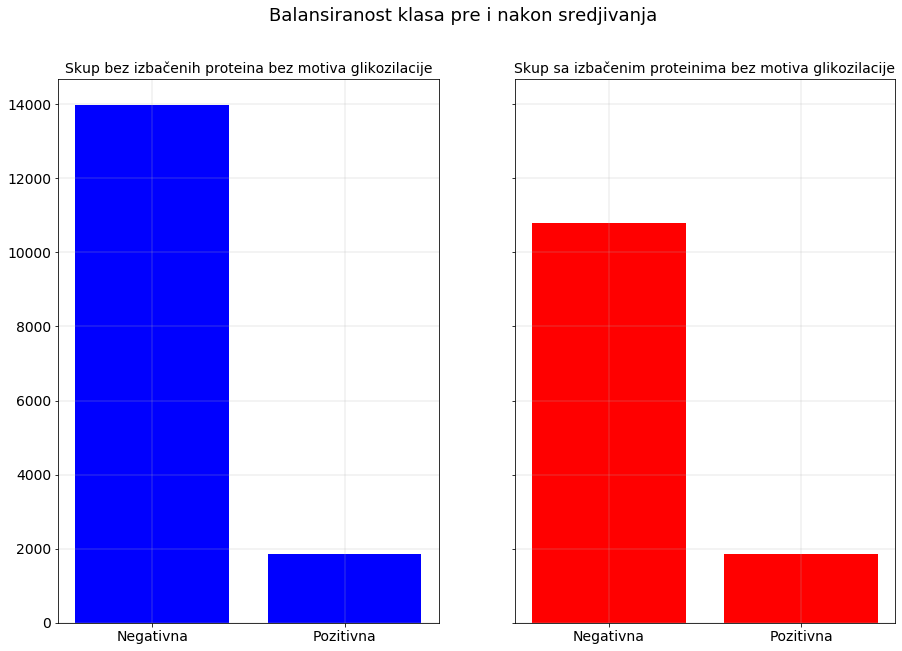

In [50]:
# Vizualizacija balansiranosti klasa pre i nakon izbacivanja proteina bez motiva N-glikozilacije

y_staro = df_sve_staro['Klasa'].values

fig, (ax1, ax2) = plt.subplots (1, 2, figsize = (15, 10), sharey = True)
plt.suptitle ('Balansiranost klasa pre i nakon sredjivanja')

ax1.set_title ('Skup bez izbačenih proteina bez motiva glikozilacije')
ax1.set_xticks (ticks = range (2))
ax1.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax1.bar ([0, 1], [sum(y_staro == 0), sum (y_staro == 1)], color = 'blue')
ax1.grid (linewidth = 0.3)

ax2.set_title ('Skup sa izbačenim proteinima bez motiva glikozilacije')
ax2.set_xticks (ticks = range (2))
ax2.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax2.bar ([0, 1], [sum(y == 0), sum (y == 1)], color = 'red')
ax2.grid (linewidth = 0.3)

plt.show()


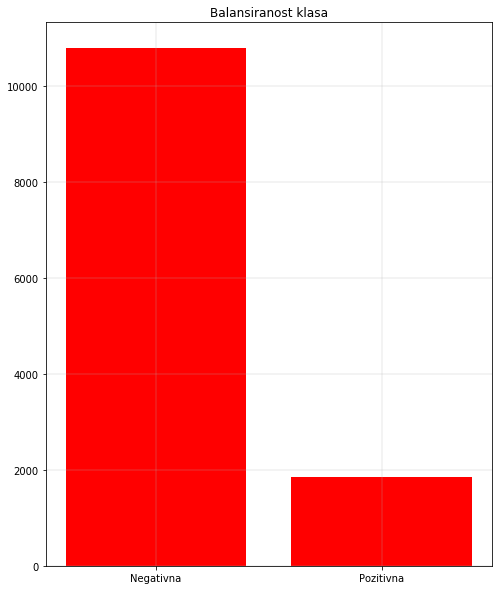

In [ ]:
# Prvo da vizualizujemo u kakvom su odnosu klase

fig = plt.figure (figsize = (8, 10))
plt.title ('Balansiranost klasa')
plt.xticks (ticks = range (2), labels = ['Negativna', 'Pozitivna'])
plt.bar ([0, 1], [sum(y == 0), sum (y == 1)], color = 'red')
plt.grid (linewidth = 0.3)
plt.show()


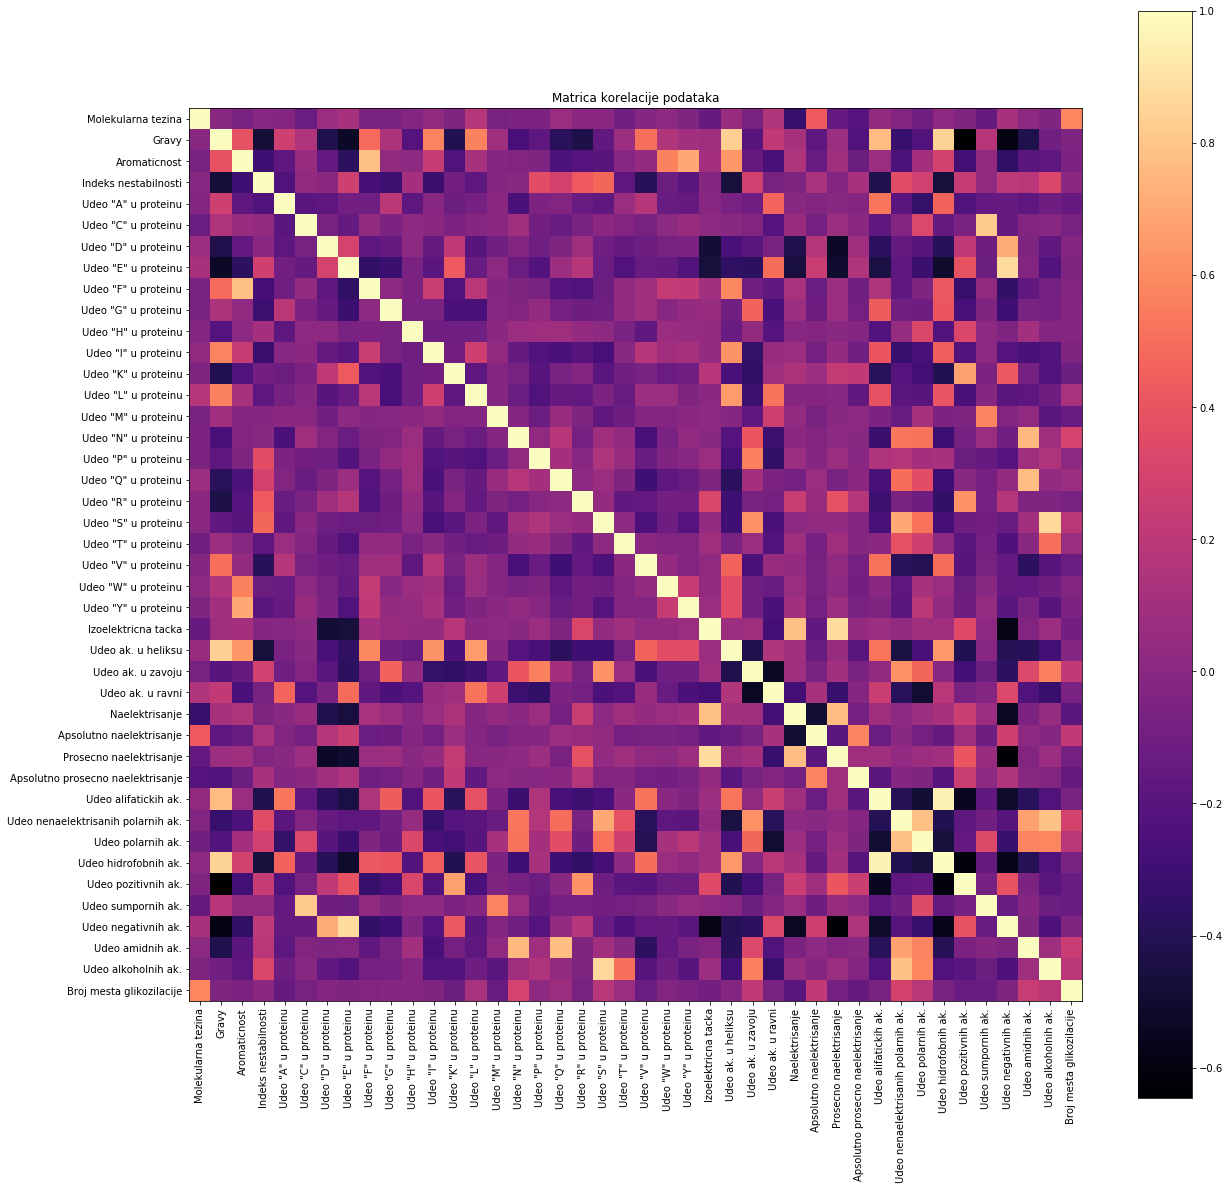

In [ ]:
# Vizualizacija podataka pomocu matrice korelacije
kolone = df_sve.columns.values

fig = plt.figure (figsize = (20, 20))
plt.title ('Matrica korelacije podataka')
plt.xticks (ticks = range (len (kolone)), labels = kolone, rotation = 90)
plt.yticks (ticks = range (len (kolone)), labels = kolone)
plt.imshow (df_sve.corr(), cmap = 'magma')
plt.colorbar()
plt.show()

# Vidimo da nije velika korelisanost podataka ni u jednom delu, sto je jako dobro


# 2. Neposredna priprema podataka zarad ispravne primene modela masinskog ucenja
## 2.1 Deljenje na skupove za trening i test

Broj proteina u x_trening skupu podataka:  (5678, 42)
Broj proteina u y_trening skupu podataka:  (5678,)
Broj proteina u x_test skupu podataka:  (4175, 42)
Broj proteina u y_test skupu podataka:  (4175,)


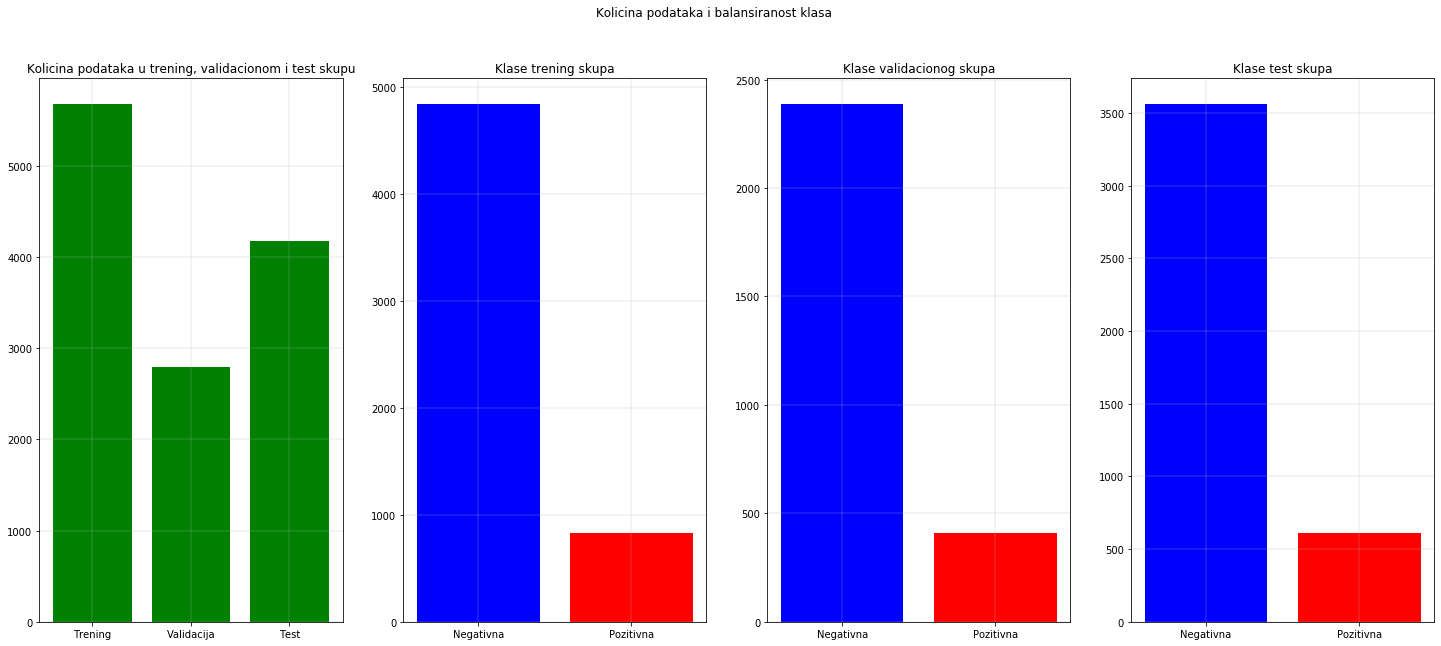

In [ ]:
# Deljenje podataka na skupove za trening, validaciju i test, 2:1 odnos svuda
# Bitan parametar predstavlja i stratifikacija po klasi, tako da imamo ujednaceno deljenje na skupove (tj. balansiranost klasa po skupovima)
X = df_sve.values

x_trening_valid, x_test, y_trening_valid, y_test = ms.train_test_split (X, y, train_size = 0.67, test_size = 0.33, stratify = y, random_state = 7)
x_trening, x_valid, y_trening, y_valid = ms.train_test_split (x_trening_valid, y_trening_valid, train_size = 0.67, test_size = 0.33, stratify = y_trening_valid, random_state = 7)

# Standardizacija podataka
skaler_1 = prep.StandardScaler()
skaler_1.fit (x_trening)
x_trening = skaler_1.transform (x_trening)
x_valid = skaler_1.transform (x_valid)

skaler_2 = prep.StandardScaler()
skaler_2.fit (x_trening_valid)
x_trening_valid = skaler_2.transform (x_trening_valid)
x_test = skaler_2.transform (x_test)

print ('Broj proteina u x_trening skupu podataka: ', x_trening.shape)
print ('Broj proteina u y_trening skupu podataka: ', y_trening.shape)
print ('Broj proteina u x_test skupu podataka: ', x_test.shape)
print ('Broj proteina u y_test skupu podataka: ', y_test.shape)

# Vizualizacija podele na trening, validacioni i test skup i balansiranosti klasa

fig, (ax1, ax2, ax3, ax4) = plt.subplots (1, 4, figsize = (25, 10))
plt.suptitle ('Kolicina podataka i balansiranost klasa')

ax1.set_title ('Kolicina podataka u trening, validacionom i test skupu')
ax1.set_xticks (ticks = range (3))
ax1.set_xticklabels (labels = ['Trening', 'Validacija', 'Test'])
ax1.bar ([0, 1, 2], [x_trening.shape[0], x_valid.shape[0], x_test.shape[0]], color = 'green')
ax1.grid (linewidth = 0.3)

ax2.set_title ('Klase trening skupa')
ax2.set_xticks (ticks = range (2))
ax2.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax2.bar ([0, 1], [sum(y_trening == 0), sum (y_trening == 1)], color = ['blue', 'red'])
ax2.grid (linewidth = 0.3)

ax3.set_title ('Klase validacionog skupa')
ax3.set_xticks (ticks = range (2))
ax3.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax3.bar ([0, 1], [sum(y_valid == 0), sum (y_valid == 1)], color = ['blue', 'red'])
ax3.grid (linewidth = 0.3)

ax4.set_title ('Klase test skupa')
ax4.set_xticks (ticks = range (2))
ax4.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax4.bar ([0, 1], [sum(y_test == 0), sum (y_test == 1)], color = ['blue', 'red'])
ax4.grid (linewidth = 0.3)

plt.show()


## 2.2 Balansiranje podataka nasumicnim podsempliranjem (pomocu _imblearn_ biblioteke)

In [ ]:
# Balansiranje podataka podsempliranjem (nasumicnim podsemplerom) i cuvanje novih podataka (radi se samo za trening skup!)
# Prvo balansiram deo koji ce se koristiti za ucenje, tj. samo trening skup

print ('Broj pozitivnih proteina trening skupa, pre balansiranja: ', sum(y_trening == 1))
print ('Broj negativnih proteina trening skupa, pre balansiranja: ', sum(y_trening == 0))

pod_sempler_1 = RandomUnderSampler(random_state = 7)
x_trening_pod, y_trening_pod = pod_sempler_1.fit_sample (x_trening, y_trening)

print ('Izgled x_trening skupa nakon podsempliranja:', x_trening_pod.shape)
print ('Izgled y_trening skupa nakon podsempliranja:', y_trening_pod.shape)

print ('Broj pozitivnih proteina trening skupa, nakon balansiranja: ', sum(y_trening_pod == 1))
print ('Broj negativnih proteina trening skupa, nakon balansiranja: ', sum(y_trening_pod == 0))

# Balansiranje dela za evaluaciju mreze, tj. trening_valid skupa

print ('\nBroj pozitivnih proteina trening_valid skupa, pre balansiranja: ', sum(y_trening_valid == 1))
print ('Broj negativnih proteina trening_valid skupa, pre balansiranja: ', sum(y_trening_valid == 0))

pod_sempler_2 = RandomUnderSampler(random_state = 7)
x_trening_valid_pod, y_trening_valid_pod = pod_sempler_2.fit_sample (x_trening_valid, y_trening_valid)

print ('Izgled x_trening_valid skupa nakon podsempliranja:', x_trening_valid_pod.shape)
print ('Izgled y_trening_valid skupa nakon podsempliranja:', y_trening_valid_pod.shape)

print ('Broj pozitivnih proteina trening_valid skupa, nakon balansiranja: ', sum(y_trening_valid_pod == 1))
print ('Broj negativnih proteina trening_valid skupa, nakon balansiranja: ', sum(y_trening_valid_pod == 0))


Broj pozitivnih proteina trening skupa, pre balansiranja:  835
Broj negativnih proteina trening skupa, pre balansiranja:  4843
Izgled x_trening skupa nakon podsempliranja: (1670, 42)
Izgled y_trening skupa nakon podsempliranja: (1670,)
Broj pozitivnih proteina trening skupa, nakon balansiranja:  835
Broj negativnih proteina trening skupa, nakon balansiranja:  835

Broj pozitivnih proteina trening_valid skupa, pre balansiranja:  1246
Broj negativnih proteina trening_valid skupa, pre balansiranja:  7230
Izgled x_trening_valid skupa nakon podsempliranja: (2492, 42)
Izgled y_trening_valid skupa nakon podsempliranja: (2492,)
Broj pozitivnih proteina trening_valid skupa, nakon balansiranja:  1246
Broj negativnih proteina trening_valid skupa, nakon balansiranja:  1246


## 2.3 Balansiranje podataka nadsempliranjem SMOTE algoritmom

In [ ]:
# Balansiranje podataka nadsempliranjem (SMOTE algoritmom, a ne nasumicnim nadsemplerom) i cuvanje novih podataka (radi se samo za trening skup!)
# Izabran je SMOTE algoritam jer je on koristi algoritam K najblizih suseda za generisanje novih podataka, samim tim daje relevantnije nove informacije
# Prvo balansiram deo koji ce se koristiti za ucenje, tj. samo trening skup

print ('Broj pozitivnih proteina trening skupa, pre balansiranja: ', sum(y_trening == 1))
print ('Broj negativnih proteina trening skupa, pre balansiranja: ', sum(y_trening == 0))

nad_sempler_smote_1 = SMOTE(random_state = 7, n_jobs = -1)
x_trening_nad_smote, y_trening_nad_smote = nad_sempler_smote_1.fit_sample (x_trening, y_trening)

print ('Izgled x_trening skupa nakon nadsempliranja:', x_trening_nad_smote.shape)
print ('Izgled y_trening skupa nakon nadsempliranja:', y_trening_nad_smote.shape)

print ('Broj pozitivnih proteina trening skupa, nakon balansiranja: ', sum(y_trening_nad_smote == 1))
print ('Broj negativnih proteina trening skupa, nakon balansiranja: ', sum(y_trening_nad_smote == 0))

# Balansiranje dela za evaluaciju mreze, tj. trening_valid skupa

print ('\nBroj pozitivnih proteina trening_valid skupa, pre balansiranja: ', sum(y_trening_valid == 1))
print ('Broj negativnih proteina trening_valid skupa, pre balansiranja: ', sum(y_trening_valid == 0))

nad_sempler_smote_2 = SMOTE(random_state = 7, n_jobs = -1)
x_trening_valid_nad_smote, y_trening_valid_nad_smote = nad_sempler_smote_2.fit_sample (x_trening_valid, y_trening_valid)

print ('Izgled x_trening_valid skupa nakon nadsempliranja:', x_trening_valid_nad_smote.shape)
print ('Izgled y_trening_valid skupa nakon nadsempliranja:', y_trening_valid_nad_smote.shape)

print ('Broj pozitivnih proteina trening_valid skupa, nakon balansiranja: ', sum(y_trening_valid_nad_smote == 1))
print ('Broj negativnih proteina trening_valid skupa, nakon balansiranja: ', sum(y_trening_valid_nad_smote == 0))


Broj pozitivnih proteina trening skupa, pre balansiranja:  835
Broj negativnih proteina trening skupa, pre balansiranja:  4843
Izgled x_trening skupa nakon nadsempliranja: (9686, 42)
Izgled y_trening skupa nakon nadsempliranja: (9686,)
Broj pozitivnih proteina trening skupa, nakon balansiranja:  4843
Broj negativnih proteina trening skupa, nakon balansiranja:  4843

Broj pozitivnih proteina trening_valid skupa, pre balansiranja:  1246
Broj negativnih proteina trening_valid skupa, pre balansiranja:  7230
Izgled x_trening_valid skupa nakon nadsempliranja: (14460, 42)
Izgled y_trening_valid skupa nakon nadsempliranja: (14460,)
Broj pozitivnih proteina trening_valid skupa, nakon balansiranja:  7230
Broj negativnih proteina trening_valid skupa, nakon balansiranja:  7230


## 2.4 Balansiranje podataka nadsempliranjem ADASYN algoritmom

In [ ]:
# Balansiranje podataka nadsempliranjem (ADASYN algoritmom, a ne nasumicnim nadsemplerom) i cuvanje novih podataka (radi se samo za trening skup!)
# ADASYN predstavlja poboljsanje SMOTE algoritma koji kreira 'realnije' podatke
# Prvo balansiram deo koji ce se koristiti za ucenje, tj. samo trening skup

print ('Broj pozitivnih proteina trening skupa, pre balansiranja: ', sum(y_trening == 1))
print ('Broj negativnih proteina trening skupa, pre balansiranja: ', sum(y_trening == 0))

nad_sempler_adasyn_1 = ADASYN(random_state = 7, n_jobs = -1)
x_trening_nad_adasyn, y_trening_nad_adasyn = nad_sempler_adasyn_1.fit_sample (x_trening, y_trening)

print ('Izgled x_trening skupa nakon nadsempliranja:', x_trening_nad_adasyn.shape)
print ('Izgled y_trening skupa nakon nadsempliranja:', y_trening_nad_adasyn.shape)

print ('Broj pozitivnih proteina trening skupa, nakon balansiranja: ', sum(y_trening_nad_adasyn == 1))
print ('Broj negativnih proteina trening skupa, nakon balansiranja: ', sum(y_trening_nad_adasyn == 0))

# Balansiranje dela za evaluaciju mreze, tj. trening_valid skupa

print ('\nBroj pozitivnih proteina trening_valid skupa, pre balansiranja: ', sum(y_trening_valid == 1))
print ('Broj negativnih proteina trening_valid skupa, pre balansiranja: ', sum(y_trening_valid == 0))

nad_sempler_adasyn_2 = ADASYN(random_state = 7, n_jobs = -1)
x_trening_valid_nad_adasyn, y_trening_valid_nad_adasyn = nad_sempler_adasyn_2.fit_sample (x_trening_valid, y_trening_valid)

print ('Izgled x_trening_valid skupa nakon nadsempliranja:', x_trening_valid_nad_adasyn.shape)
print ('Izgled y_trening_valid skupa nakon nadsempliranja:', y_trening_valid_nad_adasyn.shape)

print ('Broj pozitivnih proteina trening_valid skupa, nakon balansiranja: ', sum(y_trening_valid_nad_adasyn == 1))
print ('Broj negativnih proteina trening_valid skupa, nakon balansiranja: ', sum(y_trening_valid_nad_adasyn == 0))


Broj pozitivnih proteina trening skupa, pre balansiranja:  835
Broj negativnih proteina trening skupa, pre balansiranja:  4843
Izgled x_trening skupa nakon nadsempliranja: (9745, 42)
Izgled y_trening skupa nakon nadsempliranja: (9745,)
Broj pozitivnih proteina trening skupa, nakon balansiranja:  4902
Broj negativnih proteina trening skupa, nakon balansiranja:  4843

Broj pozitivnih proteina trening_valid skupa, pre balansiranja:  1246
Broj negativnih proteina trening_valid skupa, pre balansiranja:  7230
Izgled x_trening_valid skupa nakon nadsempliranja: (14467, 42)
Izgled y_trening_valid skupa nakon nadsempliranja: (14467,)
Broj pozitivnih proteina trening_valid skupa, nakon balansiranja:  7237
Broj negativnih proteina trening_valid skupa, nakon balansiranja:  7230


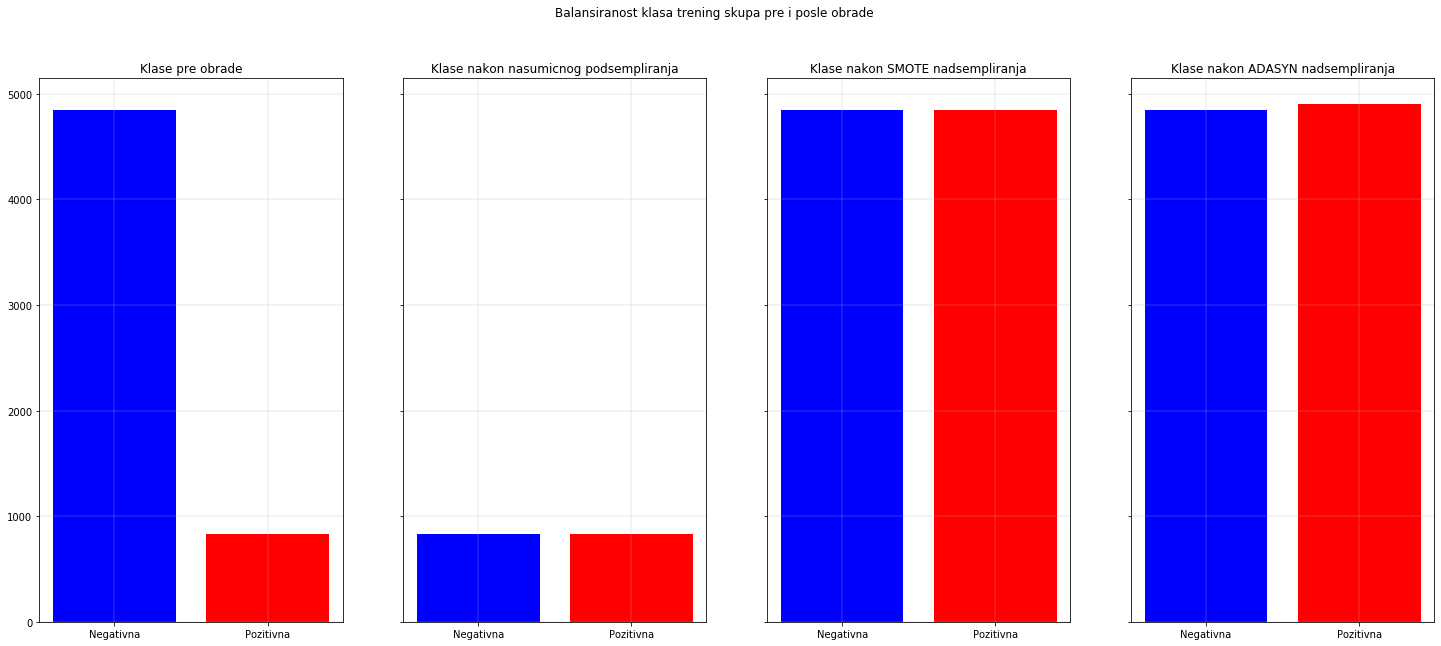

In [ ]:
# Vizualizacija polaznih podataka trening i trening_valid skupa, zatim podataka nakon podsempliranja i nakon nadsempliranja

fig, (ax1, ax2, ax3, ax4) = plt.subplots (1, 4, sharey = True, figsize = (25, 10))
plt.suptitle ('Balansiranost klasa trening skupa pre i posle obrade')

ax1.set_title ('Klase pre obrade')
ax1.set_xticks (ticks = range (2))
ax1.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax1.bar ([0, 1], [sum(y_trening == 0), sum (y_trening == 1)], color = ['blue', 'red'])
ax1.grid (linewidth = 0.3)

ax2.set_title ('Klase nakon nasumicnog podsempliranja')
ax2.set_xticks (ticks = range (2))
ax2.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax2.bar ([0, 1], [sum(y_trening_pod == 0), sum (y_trening_pod == 1)], color = ['blue', 'red'])
ax2.grid (linewidth = 0.3)

ax3.set_title ('Klase nakon SMOTE nadsempliranja')
ax3.set_xticks (ticks = range (2))
ax3.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax3.bar ([0, 1], [sum(y_trening_nad_smote == 0), sum (y_trening_nad_smote == 1)], color = ['blue', 'red'])
ax3.grid (linewidth = 0.3)

ax4.set_title ('Klase nakon ADASYN nadsempliranja')
ax4.set_xticks (ticks = range (2))
ax4.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax4.bar ([0, 1], [sum(y_trening_nad_adasyn == 0), sum (y_trening_nad_adasyn == 1)], color = ['blue', 'red'])
ax4.grid (linewidth = 0.3)

plt.show()


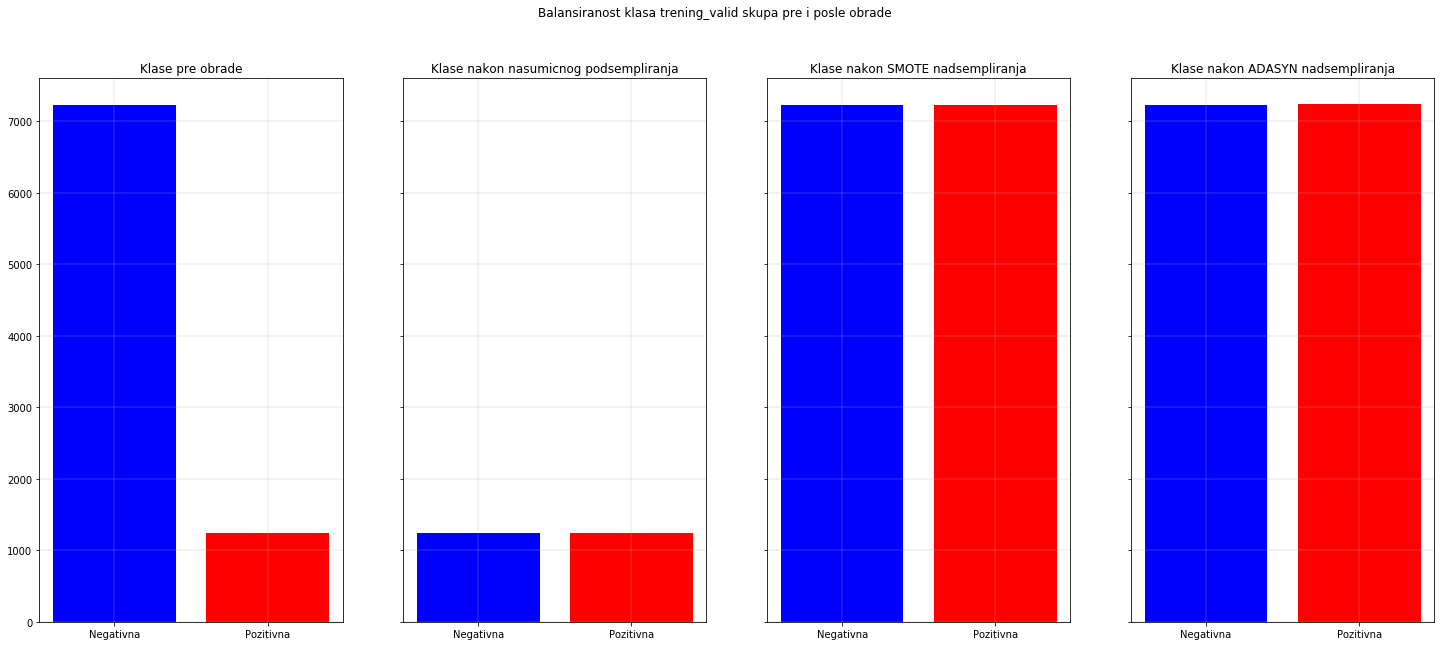

In [ ]:
# Sad validacioni

fig, (ax1, ax2, ax3, ax4) = plt.subplots (1, 4, sharey = True, figsize = (25, 10))
plt.suptitle ('Balansiranost klasa trening_valid skupa pre i posle obrade')

ax1.set_title ('Klase pre obrade')
ax1.set_xticks (ticks = range (2))
ax1.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax1.bar ([0, 1], [sum(y_trening_valid == 0), sum (y_trening_valid == 1)], color = ['blue', 'red'])
ax1.grid (linewidth = 0.3)

ax2.set_title ('Klase nakon nasumicnog podsempliranja')
ax2.set_xticks (ticks = range (2))
ax2.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax2.bar ([0, 1], [sum(y_trening_valid_pod == 0), sum (y_trening_valid_pod == 1)], color = ['blue', 'red'])
ax2.grid (linewidth = 0.3)

ax3.set_title ('Klase nakon SMOTE nadsempliranja')
ax3.set_xticks (ticks = range (2))
ax3.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax3.bar ([0, 1], [sum(y_trening_valid_nad_smote == 0), sum (y_trening_valid_nad_smote == 1)], color = ['blue', 'red'])
ax3.grid (linewidth = 0.3)

ax4.set_title ('Klase nakon ADASYN nadsempliranja')
ax4.set_xticks (ticks = range (2))
ax4.set_xticklabels (labels = ['Negativna', 'Pozitivna'])
ax4.bar ([0, 1], [sum(y_trening_valid_nad_adasyn == 0), sum (y_trening_valid_nad_adasyn == 1)], color = ['blue', 'red'])
ax4.grid (linewidth = 0.3)

plt.show()


In [ ]:
# Funkcija za lepo iscrtavanje matrice konfuzije
# Preuzeta i modifikovana za potrebe rada sa zvanicnog sajta biblioteke SciKit-Learn:
# https://scikit-learn.org/0.21/auto_examples/model_selection/plot_confusion_matrix.html
def nacrtaj_matricu_konfuzije (y_test, y_procena, ime_modela):
    
    #plt.style.use ('dark_background')
    mat_konf = met.confusion_matrix(y_test, y_procena)
    
    # Kreiranje normalizovane verzije matrice konfuzije
    norm_mat_konf = mat_konf.astype('float') / mat_konf.sum(axis=1)[:, np.newaxis]
    
    klase = np.unique (np.hstack ((y_test, y_procena)))
    
    # Kreiranje grafika za svaku od matrica
    fig, (ax_1, ax_2) = plt.subplots (1, 2, figsize = (20, 10))
    plt.suptitle ('Matrice konfuzije za model: ' + ime_modela)
    
    slika_1 = ax_1.imshow (mat_konf, interpolation = 'nearest', cmap = 'Reds')
    ax_1.figure.colorbar (slika_1, ax = ax_1, shrink = 0.8)
    
    slika_2 = ax_2.imshow (norm_mat_konf, interpolation = 'nearest', cmap = 'Reds')
    ax_2.figure.colorbar (slika_2, ax = ax_2, shrink = 0.8)
    
    ax_1.set (xticks = np.arange (mat_konf.shape[1]),
              yticks = np.arange (mat_konf.shape[0]),
              xticklabels = klase,
              yticklabels = klase,
              title = 'Matrica konfuzije bez normalizacije',
              ylabel = 'Stvarne vrednosti',
              xlabel = 'Procenjene vrednosti')
    
    ax_2.set (xticks = np.arange (norm_mat_konf.shape[1]),
              yticks = np.arange (norm_mat_konf.shape[0]),
              xticklabels = klase,
              yticklabels = klase,
              title = 'Normalizovana matrica konfuzije',
              ylabel = 'Stvarne vrednosti',
              xlabel = 'Procenjene vrednosti')
    
    # Potrebno zbog baga u trenutnoj verziji Matplotlib-a 3.1.1, izbrisati nakon nadogradnje
    # Bag: https://github.com/matplotlib/matplotlib/issues/15154
    ################################################################
    ax_1.set_ylim (mat_konf.shape[0] - 0.5, -0.5)
    ax_2.set_ylim (norm_mat_konf.shape[0] - 0.5, -0.5)
    ################################################################
    
    plt.setp (ax_1.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")
    plt.setp (ax_2.get_xticklabels(), rotation = 45, ha = "right", rotation_mode = "anchor")
    
    tekst = [['Stvarno negativni\n','Lazno pozitivni\n'], ['Lazno negativni\n', 'Stvarno pozitivni\n']]
    
    for i in range (mat_konf.shape[0]):
        for j in range(mat_konf.shape[1]):
            ax_1.text (j, i, str (tekst[i][j]) + format(mat_konf[i, j], 'g'), horizontalalignment = 'center', verticalalignment = 'center', bbox = dict (facecolor = 'gray', alpha = 0.9))
            ax_2.text (j, i, str (tekst[i][j]) + format(norm_mat_konf[i, j], 'g'), horizontalalignment = 'center', verticalalignment = 'center', bbox = dict (facecolor = 'gray', alpha = 0.9))
    
    fig.tight_layout()
    
    return ax_1, ax_2

# Funkcija za iscrtavanje grafika ucenja mreze (tacnost i greska) nad razlicitim skupovima
def nacrtaj_ucenje (istorija, ime_modela):
    
    tacnost = istorija.history ['binary_accuracy']
    val_tacnost = istorija.history ['val_binary_accuracy']
    greska = istorija.history ['loss']
    val_greska = istorija.history ['val_loss']
    
    fig, (ax1, ax2) = plt.subplots (1, 2, figsize = (20, 10))
    plt.suptitle ('Grafici tacnosti i greske za model: ' + ime_modela)
    
    ax1.set_title ('Grafik tacnosti modela u zavisnosti od epohe')
    ax1.set_xlabel ('Epoha')
    ax1.set_ylabel ('Binarna Tacnost')
    ax1.plot (istorija.epoch, tacnost, c = 'r', label = 'Trening')
    ax1.plot (istorija.epoch, val_tacnost, c = 'g', label = 'Validacija')
    ax1.grid (linewidth = 0.3)
    ax1.legend()
    
    ax2.set_title ('Grafik greske modela u zavisnosti od epohe')
    ax2.set_xlabel ('Epoha')
    ax2.set_ylabel ('Greska')
    ax2.plot (istorija.epoch, greska, c = 'r', label = 'Trening')
    ax2.plot (istorija.epoch, val_greska, c = 'g', label = 'Validacija')
    ax2.grid (linewidth = 0.3)
    ax2.legend()
    
    plt.show()


# 3. Primena potpuno povezane neuronske mreze nad razlicito balansiranim skpovima podataka

In [ ]:
# Definisanje parametara svih mreza
dim_ulaza = len (kolone)
dim_izlaza = 1

#########################################################################################################
# Vrednosti koje sam prvobitno koristio

# inicijalizatori = ['uniform', 'normal', 'lecun_normal', 'lecun_uniform', 'he_normal', 'he_uniform', 'glorot_normal', 'glorot_uniform']
# optimizatori = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
# vel_grupa = [32, 64]
#########################################################################################################

# Nove vrednosti, nakon odluke da se varira arhitektura

inicijalizatori = ['he_normal', 'he_uniform', 'glorot_normal', 'glorot_uniform']
optimizatori = ['RMSprop', 'Nadam']
vel_grupa = [32]
br_neurona_1 = [30, 25, 20] # Za potencijalni prvi skriveni sloj
br_neurona_2 = [18, 15, 13] # Za potencijalni drugi skriveni sloj
br_neurona_3 = [10, 8, 5] # Za potencijalni treci skriveni sloj

kolbekovi = [EarlyStopping (monitor = 'val_loss', patience = 13, restore_best_weights = True)]

epohe = 200


In [ ]:
# Sa jednim skrivenim slojem
def napravi_mrezu_1 (optimizer, kernel_initializer, br_neur_1):
	
    K.clear_session()
    mreza = Sequential()
    mreza.add (Dense (units = br_neur_1, input_dim = dim_ulaza, kernel_initializer = kernel_initializer))
    mreza.add (BatchNormalization())
    mreza.add (Activation('relu'))
    mreza.add (Dense (units = dim_izlaza))
    mreza.add (BatchNormalization())
    mreza.add (Activation('sigmoid'))

    mreza.compile (optimizer = optimizer, loss = losses.binary_crossentropy, metrics = [ker_met.binary_accuracy
])
    
    return mreza

# Sa dva skrivena sloja
def napravi_mrezu_2 (optimizer, kernel_initializer, br_neur_1, br_neur_2):
	
    K.clear_session()
    mreza = Sequential()
    mreza.add (Dense (units = br_neur_1, input_dim = dim_ulaza, kernel_initializer = kernel_initializer))
    mreza.add (BatchNormalization())
    mreza.add (Activation('relu'))
    mreza.add (Dense (units = br_neur_2, input_dim = dim_ulaza, kernel_initializer = kernel_initializer))
    mreza.add (BatchNormalization())
    mreza.add (Activation('relu'))
    mreza.add (Dense (units = dim_izlaza))
    mreza.add (BatchNormalization())
    mreza.add (Activation('sigmoid'))

    mreza.compile (optimizer = optimizer, loss = losses.binary_crossentropy, metrics = [ker_met.binary_accuracy])
    
    return mreza

# Sa tri skrivena sloja
def napravi_mrezu_3 (optimizer, kernel_initializer, br_neur_1, br_neur_2, br_neur_3):
	
    K.clear_session()
    mreza = Sequential()
    mreza.add (Dense (units = br_neur_1, input_dim = dim_ulaza, kernel_initializer = kernel_initializer))
    mreza.add (BatchNormalization())
    mreza.add (Activation('relu'))
    mreza.add (Dense (units = br_neur_2, input_dim = dim_ulaza, kernel_initializer = kernel_initializer))
    mreza.add (BatchNormalization())
    mreza.add (Activation('relu'))
    mreza.add (Dense (units = br_neur_3, input_dim = dim_ulaza, kernel_initializer = kernel_initializer))
    mreza.add (BatchNormalization())
    mreza.add (Activation('relu'))
    mreza.add (Dense (units = dim_izlaza))
    mreza.add (BatchNormalization())
    mreza.add (Activation('sigmoid'))

    mreza.compile (optimizer = optimizer, loss = losses.binary_crossentropy, metrics = [ker_met.binary_accuracy])
    
    return mreza
  

In [ ]:
# Pomocne funkcije za nalazenje optimalnih parametara prateci f1 meru

def nadji_najbolje_parametre (X_TREN, Y_TREN, X_VAL, Y_VAL, X_TEST, Y_TEST, BR_SLOJA, TEZINA_KLASA = None):
  
  najb_f1 = 0
  i = 0
  poc_vreme = timer()
  
  if BR_SLOJA == 1:
    
    najb_par = {'opt' : '', 'kern_ini' : '', 'batch_size' : 0, 'br_n_1' : 0}
    ukupno_prolaza = len(br_neurona_1) * len(optimizatori) * len(inicijalizatori) * len(vel_grupa)
    print ('Ukupan broj prolaza:', ukupno_prolaza)
    
    for br_n_1 in br_neurona_1:
      for op in optimizatori:
        for inic in inicijalizatori:
          for v_g in vel_grupa:

            mreza = napravi_mrezu_1 (optimizer = op, kernel_initializer = inic, br_neur_1 = br_n_1)
            mreza.fit (X_TREN, Y_TREN, validation_data = (X_VAL, Y_VAL), epochs = epohe, batch_size = v_g, callbacks = kolbekovi, class_weight = TEZINA_KLASA, verbose = 0)

            y_procena = mreza.predict(X_TEST)
            y_procena_zaok = np.rint (y_procena)
            izvestaj = met.classification_report (Y_TEST, y_procena_zaok, output_dict = True)

            if izvestaj['1']['f1-score'] > najb_f1:
              najb_f1 = izvestaj['1']['f1-score']
              najb_par['opt'] = op
              najb_par['kern_ini'] = inic
              najb_par['batch_size'] = v_g
              najb_par['br_n_1'] = br_n_1
              print ('Novi f1 skor:', najb_f1)
            
            i += 1
            if (ukupno_prolaza // 4 == i) or (ukupno_prolaza // 2 == i) or (3 * ukupno_prolaza // 4 == i):
              print ('Prolaz:', i)

  elif BR_SLOJA == 2:
    
    najb_par = {'opt' : '', 'kern_ini' : '', 'batch_size' : 0, 'br_n_1' : 0, 'br_n_2' : 0}
    ukupno_prolaza = len(br_neurona_1) * len(br_neurona_2) * len(optimizatori) * len(inicijalizatori) * len(vel_grupa)
    print ('Ukupan broj prolaza:', ukupno_prolaza)
    
    for br_n_1 in br_neurona_1:
      for br_n_2 in br_neurona_2:
        for op in optimizatori:
          for inic in inicijalizatori:
            for v_g in vel_grupa:
              
              mreza = napravi_mrezu_2 (optimizer = op, kernel_initializer = inic, br_neur_1 = br_n_1, br_neur_2 = br_n_2)
              mreza.fit (X_TREN, Y_TREN, validation_data = (X_VAL, Y_VAL), epochs = epohe, batch_size = v_g, callbacks = kolbekovi, class_weight = TEZINA_KLASA, verbose = 0)

              y_procena = mreza.predict(X_TEST)
              y_procena_zaok = np.rint (y_procena)
              izvestaj = met.classification_report (Y_TEST, y_procena_zaok, output_dict = True)

              if izvestaj['1']['f1-score'] > najb_f1:
                najb_f1 = izvestaj['1']['f1-score']
                najb_par['opt'] = op
                najb_par['kern_ini'] = inic
                najb_par['batch_size'] = v_g
                najb_par['br_n_1'] = br_n_1
                najb_par['br_n_2'] = br_n_2
                print ('Novi f1 skor:', najb_f1)

              i += 1
              if (ukupno_prolaza // 4 == i) or (ukupno_prolaza // 2 == i) or (3 * ukupno_prolaza // 4 == i):
                print ('Prolaz:', i)
  
  else:
    
    najb_par = {'opt' : '', 'kern_ini' : '', 'batch_size' : 0, 'br_n_1' : 0, 'br_n_2' : 0, 'br_n_3' : 0}
    ukupno_prolaza = len(br_neurona_1) * len(br_neurona_2) * len(br_neurona_3) * len(optimizatori) * len(inicijalizatori) * len(vel_grupa)
    print ('Ukupan broj prolaza:', ukupno_prolaza)
    
    for br_n_1 in br_neurona_1:
      for br_n_2 in br_neurona_2:
        for br_n_3 in br_neurona_3:
          for op in optimizatori:
            for inic in inicijalizatori:
              for v_g in vel_grupa:

                mreza = napravi_mrezu_3 (optimizer = op, kernel_initializer = inic, br_neur_1 = br_n_1, br_neur_2 = br_n_2, br_neur_3 = br_n_3)
                mreza.fit (X_TREN, Y_TREN, validation_data = (X_VAL, Y_VAL), epochs = epohe, batch_size = v_g, callbacks = kolbekovi, class_weight = TEZINA_KLASA, verbose = 0)

                y_procena = mreza.predict(X_TEST)
                y_procena_zaok = np.rint (y_procena)
                izvestaj = met.classification_report (Y_TEST, y_procena_zaok, output_dict = True)

                if izvestaj['1']['f1-score'] > najb_f1:
                  najb_f1 = izvestaj['1']['f1-score']
                  najb_par['opt'] = op
                  najb_par['kern_ini'] = inic
                  najb_par['batch_size'] = v_g
                  najb_par['br_n_1'] = br_n_1
                  najb_par['br_n_2'] = br_n_2
                  najb_par['br_n_3'] = br_n_3
                  print ('Novi f1 skor:', najb_f1)

                i += 1
                if (ukupno_prolaza // 4 == i) or (ukupno_prolaza // 2 == i) or (3 * ukupno_prolaza // 4 == i):
                  print ('Prolaz:', i)
  
  kraj_vreme = timer()
  print ('Proteklo vreme:', timedelta(seconds = kraj_vreme - poc_vreme))
  
  print ('Najbolji parametri:\n', najb_par)
  return najb_par


## 3.1 Polazni skup podataka nad kojim nisu primenjene tehnike balansiranja

### 3.1.1 Potpuno povezana neuronska mreza bez ukljucenog class_weight parametra (koji uzima u obzir nebalansiranost klasa pri ucenju) sa jednim skrivenim slojem


In [ ]:
# Zakomentarisani delovi u nastavku se odnose na primenu ugradjenih funkcija unakrsne validacije
# za nalazenje optimalnih parametara. Usled duzine ovog procesa, on je napusten. Ipak, kod je 
# ostavljen kao alternativna verzija resavanja
# Treniranje mreze sa jednim skrivenim slojem
# Vreme izvrsavanja ~ 50 min., 30 min. za drugi slucaj
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_1, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1 + br_neurona_2, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening, y_trening, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''

najb_parametri =  nadji_najbolje_parametre (x_trening, y_trening, x_valid, y_valid, x_test, y_test, 1)


Ukupan broj prolaza: 24








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Novi f1 skor: 0.6546830652790918
Novi f1 skor: 0.6865942028985508
Prolaz: 6
Prolaz: 12
Prolaz: 18
Proteklo vreme: 0:33:07.434587
Najbolji parametri:
 {'opt': 'RMSprop', 'kern_ini': 'glorot_normal', 'batch_size': 32, 'br_n_1': 30}


In [ ]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur = mreza_2.best_params_['br_neur_1']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona:', najb_br_neur)
'''

najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur = najb_parametri['br_n_1']


In [ ]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
mreza_nebal = napravi_mrezu_1 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur)
mreza_nebal.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                1290      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
activation_1 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
_________________________________________________________________
batch_normalization_2 (Batch (None, 1)                 4         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 1,445
Trainable params: 1,383
Non-trainable params: 62
___________________________________________________

In [ ]:
istorija = mreza_nebal.fit (x_trening, y_trening, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)

Train on 5678 samples, validate on 2798 samples
Epoch 1/200
5678/5678 [==============================] - 2s 355us/step - loss: 0.6230 - binary_accuracy: 0.6995 - val_loss: 0.5110 - val_binary_accuracy: 0.8091
Epoch 2/200
5678/5678 [==============================] - 1s 257us/step - loss: 0.5222 - binary_accuracy: 0.8094 - val_loss: 0.4615 - val_binary_accuracy: 0.8592
Epoch 3/200
5678/5678 [==============================] - 1s 257us/step - loss: 0.4648 - binary_accuracy: 0.8485 - val_loss: 0.4115 - val_binary_accuracy: 0.8871
Epoch 4/200
5678/5678 [==============================] - 1s 264us/step - loss: 0.4235 - binary_accuracy: 0.8698 - val_loss: 0.3760 - val_binary_accuracy: 0.8999
Epoch 5/200
5678/5678 [==============================] - 1s 259us/step - loss: 0.3867 - binary_accuracy: 0.8827 - val_loss: 0.3473 - val_binary_accuracy: 0.9089
Epoch 6/200
5678/5678 [==============================] - 1s 259us/step - loss: 0.3541 - binary_accuracy: 0.8943 - val_loss: 0.3175 - val_binary_acc

In [ ]:
y_procena = mreza_nebal.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije nebalansirane potpuno povezane mreze sa jednim skrivenim slojem:\n', met.classification_report (y_test, y_procena_zaok))

Izvestaj klasifikacije nebalansirane potpuno povezane mreze sa jednim skrivenim slojem:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      3561
           1       0.78      0.60      0.68       614

    accuracy                           0.92      4175
   macro avg       0.85      0.78      0.81      4175
weighted avg       0.91      0.92      0.91      4175



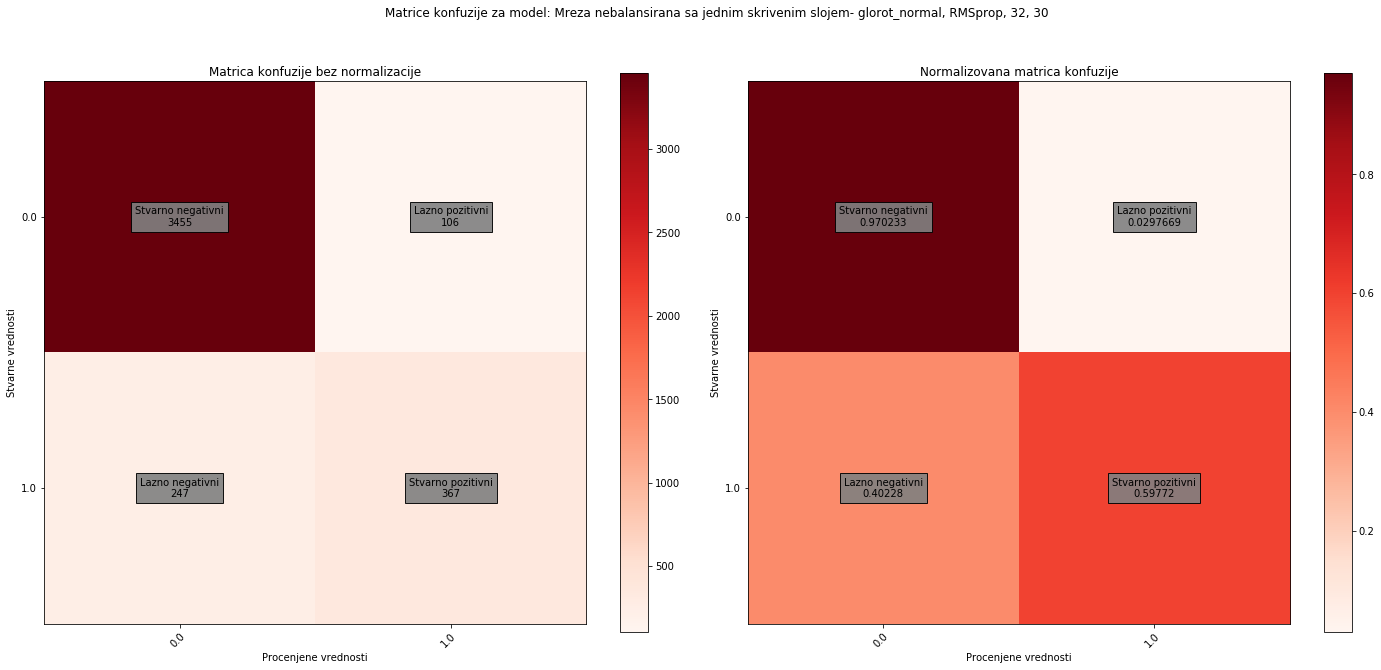

In [ ]:
ime = 'Mreza nebalansirana sa jednim skrivenim slojem- ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()


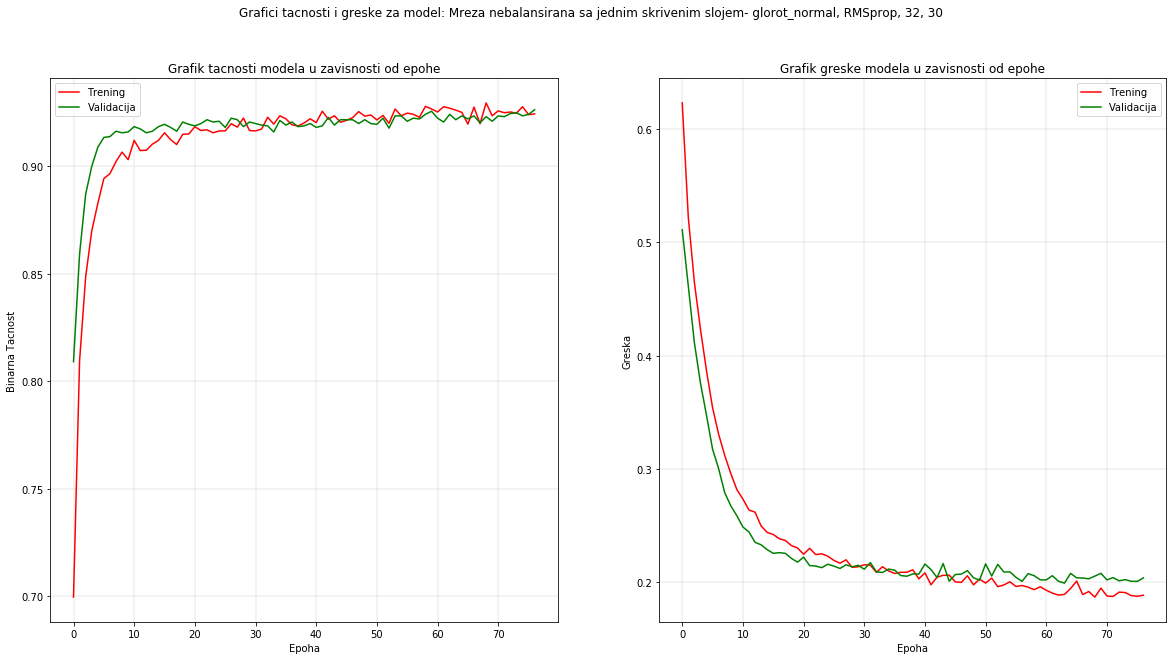

In [ ]:
nacrtaj_ucenje (istorija, ime)


### 3.1.2 Potpuno povezana neuronska mreza bez ukljucenog class_weight parametra (koji uzima u obzir nebalansiranost klasa pri ucenju) sa dva skrivena sloja


In [ ]:
# Treniranje mreze sa dva skrivena sloja
# Vreme izvrsavanja ~ 2h 48 min., 2h
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_2, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1, br_neur_2 =  br_neurona_2, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening, y_trening, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''
najb_parametri =  nadji_najbolje_parametre (x_trening, y_trening, x_valid, y_valid, x_test, y_test, 2)


Ukupan broj prolaza: 72
Novi f1 skor: 0.6831955922865014
Novi f1 skor: 0.7020702070207021
Prolaz: 18
Novi f1 skor: 0.7024029574861369
Prolaz: 36
Prolaz: 54
Novi f1 skor: 0.702851885924563
Proteklo vreme: 1:56:16.864473
Najbolji parametri:
 {'opt': 'Nadam', 'kern_ini': 'glorot_normal', 'batch_size': 32, 'br_n_1': 20, 'br_n_2': 13}


In [ ]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur_1 = mreza_2.best_params_['br_neur_1']
najb_br_neur_2 = mreza_2.best_params_['br_neur_2']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona prvog sloja:', najb_br_neur_1)
print ('Broj neurona drugog sloja:', najb_br_neur_2)
'''
najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur_1 = najb_parametri['br_n_1']
najb_br_neur_2 = najb_parametri['br_n_2']

In [ ]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
mreza_nebal = napravi_mrezu_2 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur_1, br_neur_2 = najb_br_neur_2)
mreza_nebal.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                860       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                273       
_________________________________________________________________
batch_normalization_2 (Batch (None, 13)                52        
_________________________________________________________________
activation_2 (Activation)    (None, 13)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
istorija = mreza_nebal.fit (x_trening, y_trening, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)

Train on 5678 samples, validate on 2798 samples
Epoch 1/200
5678/5678 [==============================] - 3s 549us/step - loss: 0.5911 - binary_accuracy: 0.7022 - val_loss: 0.5569 - val_binary_accuracy: 0.7813
Epoch 2/200
5678/5678 [==============================] - 2s 386us/step - loss: 0.4555 - binary_accuracy: 0.8579 - val_loss: 0.4306 - val_binary_accuracy: 0.8928
Epoch 3/200
5678/5678 [==============================] - 2s 392us/step - loss: 0.3852 - binary_accuracy: 0.8897 - val_loss: 0.3423 - val_binary_accuracy: 0.9124
Epoch 4/200
5678/5678 [==============================] - 2s 391us/step - loss: 0.3397 - binary_accuracy: 0.9024 - val_loss: 0.3011 - val_binary_accuracy: 0.9207
Epoch 5/200
5678/5678 [==============================] - 2s 393us/step - loss: 0.3104 - binary_accuracy: 0.9074 - val_loss: 0.2750 - val_binary_accuracy: 0.9214
Epoch 6/200
5678/5678 [==============================] - 2s 412us/step - loss: 0.2925 - binary_accuracy: 0.9070 - val_loss: 0.2605 - val_binary_acc

In [ ]:
y_procena = mreza_nebal.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije nebalansirane potpuno povezane mreze sa dva skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))

Izvestaj klasifikacije nebalansirane potpuno povezane mreze sa dva skrivena sloja:
               precision    recall  f1-score   support

           0       0.93      0.97      0.95      3561
           1       0.77      0.61      0.68       614

    accuracy                           0.92      4175
   macro avg       0.85      0.79      0.82      4175
weighted avg       0.91      0.92      0.91      4175



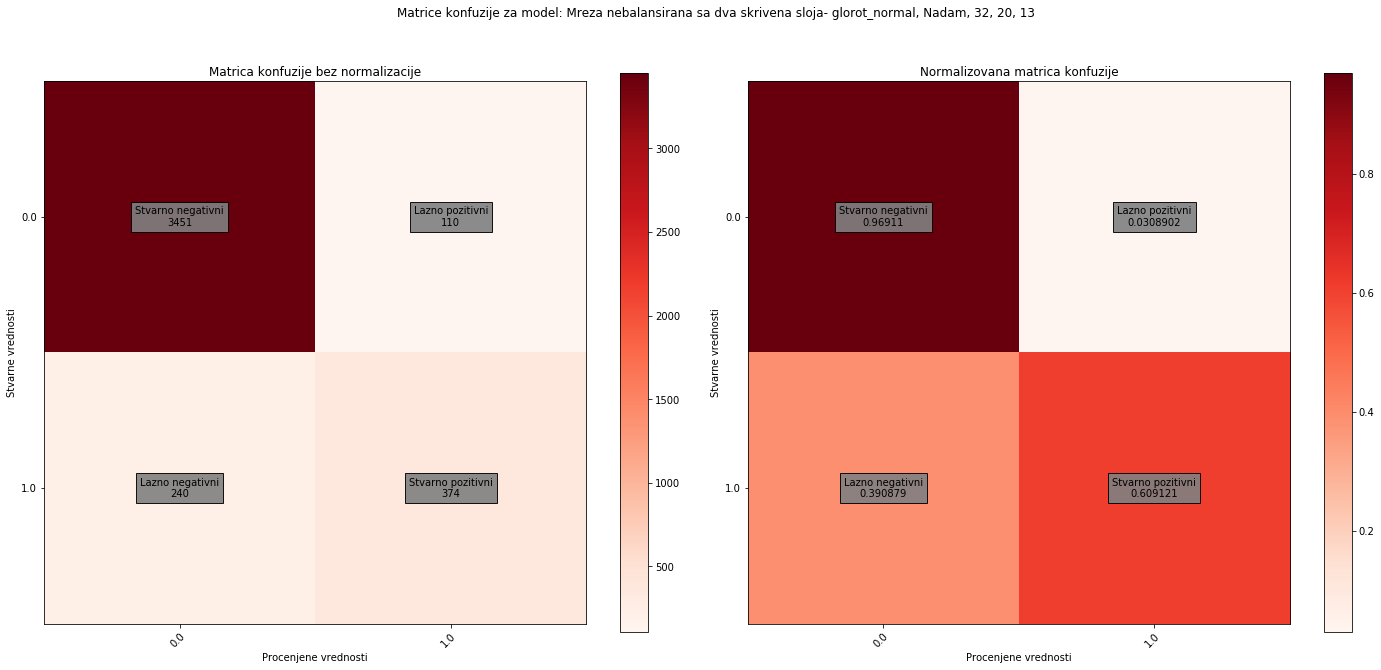

In [ ]:
ime = 'Mreza nebalansirana sa dva skrivena sloja- ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()


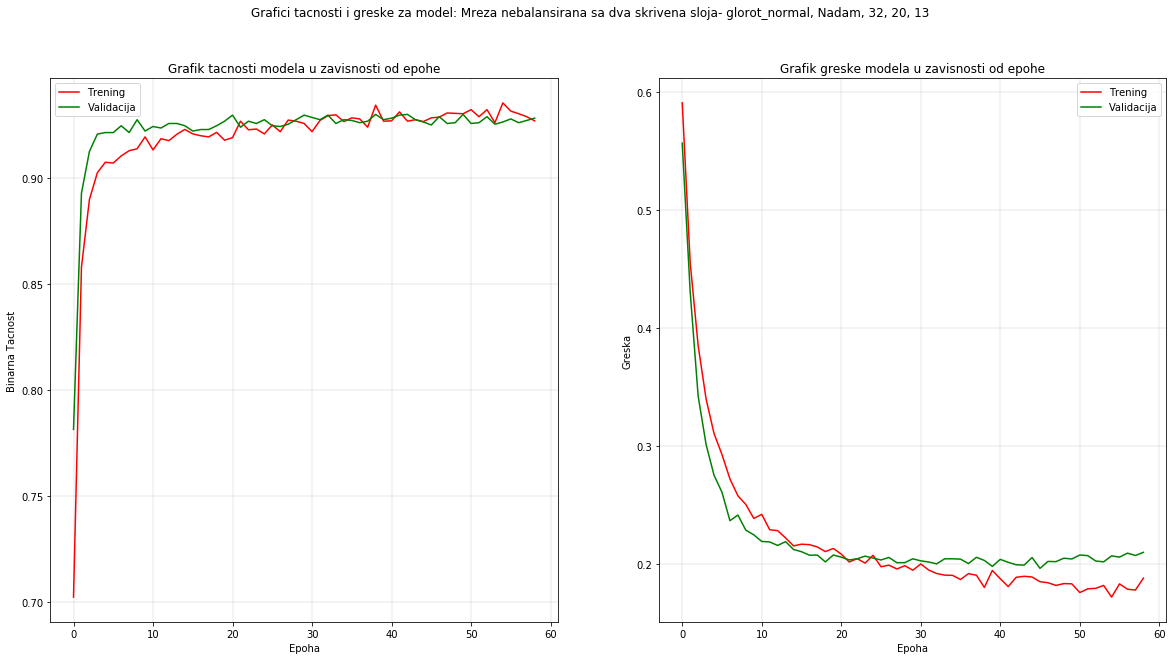

In [ ]:
nacrtaj_ucenje (istorija, ime)


In [ ]:
# Treniranje mreze sa tri skrivena sloja

'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_3, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1, br_neur_2 =  br_neurona_2, br_neur_3 =  br_neurona_3, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening, y_trening, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''

#najb_parametri =  nadji_najbolje_parametre (x_trening, y_trening, x_valid, y_valid, x_test, y_test, 3)


"\nmreza_1 = KerasClassifier (build_fn = napravi_mrezu_3, verbose=0)\n\nparametri = dict (br_neur_1 = br_neurona_1, br_neur_2 =  br_neurona_2, br_neur_3 =  br_neurona_3, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)\n\nmreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)\nmreza_2.fit (x_trening, y_trening, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)\n"

In [ ]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur_1 = mreza_2.best_params_['br_neur_1']
najb_br_neur_2 = mreza_2.best_params_['br_neur_2']
najb_br_neur_3 = mreza_2.best_params_['br_neur_3']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona prvog sloja:', najb_br_neur_1)
print ('Broj neurona drugog sloja:', najb_br_neur_2)
print ('Broj neurona treceg sloja:', najb_br_neur_3)


najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur_1 = najb_parametri['br_n_1']
najb_br_neur_2 = najb_parametri['br_n_2']
najb_br_neur_3 = najb_parametri['br_n_3']
'''

"\nnajb_opt = mreza_2.best_params_['optimizer']\nnajb_inic = mreza_2.best_params_['kernel_initializer']\nnajb_vel = mreza_2.best_params_['batch_size']\nnajb_br_neur_1 = mreza_2.best_params_['br_neur_1']\nnajb_br_neur_2 = mreza_2.best_params_['br_neur_2']\nnajb_br_neur_3 = mreza_2.best_params_['br_neur_3']\n\nprint ('Najbolji parametri mreze su:')\nprint ('Kernel initializer:', najb_inic)\nprint ('Optimizer:', najb_opt)\nprint ('Batch size:', najb_vel)\nprint ('Broj neurona prvog sloja:', najb_br_neur_1)\nprint ('Broj neurona drugog sloja:', najb_br_neur_2)\nprint ('Broj neurona treceg sloja:', najb_br_neur_3)\n\n\nnajb_opt = najb_parametri['opt']\nnajb_inic = najb_parametri['kern_ini']\nnajb_vel = najb_parametri['batch_size']\nnajb_br_neur_1 = najb_parametri['br_n_1']\nnajb_br_neur_2 = najb_parametri['br_n_2']\nnajb_br_neur_3 = najb_parametri['br_n_3']\n"

In [ ]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
#mreza_nebal = napravi_mrezu_3 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur_1, br_neur_2 = najb_br_neur_2, br_neur_3 = najb_br_neur_3)
#mreza_nebal.summary()


In [ ]:
#istorija = mreza_nebal.fit (x_trening, y_trening, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)

In [ ]:
'''
y_procena = mreza_nebal.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije nebalansirane potpuno povezane mreze sa tri skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))
'''

"\ny_procena = mreza_nebal.predict(x_test)\ny_procena_zaok = np.rint (y_procena)\n\nprint ('Izvestaj klasifikacije nebalansirane potpuno povezane mreze sa tri skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))\n"

In [ ]:
'''
ime = 'Mreza nebalansirana sa tri skrivena sloja- ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2) + ', ' + str(najb_br_neur_3))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()
'''

"\nime = 'Mreza nebalansirana sa tri skrivena sloja- ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2) + ', ' + str(najb_br_neur_3))\nnacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)\nplt.show()\n"

In [ ]:
#nacrtaj_ucenje (istorija, ime)


### 3.1.3 Potpuno povezana neuronska mreza sa ukljucenim class_weight parametrom (koji uzima u obzir nebalansiranost klasa pri ucenju) sa jednim skrivenim slojem


In [ ]:
# Racunanje tezina klasa
# Treniranje mreze sa jednim skrivenim slojem
# Vreme izvrsavanja ~ 50 min., 36 min.
tezine_klasa = cw.compute_class_weight('balanced', np.unique(y_trening_valid), y_trening_valid)
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_1, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1 + br_neurona_2, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening, y_trening, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi, class_weight = tezine_klasa)
'''

najb_parametri =  nadji_najbolje_parametre (x_trening, y_trening, x_valid, y_valid, x_test, y_test, 1, tezine_klasa)


Ukupan broj prolaza: 24
Novi f1 skor: 0.6716003700277521
Novi f1 skor: 0.6863468634686347
Novi f1 skor: 0.6891651865008881
Prolaz: 6
Novi f1 skor: 0.6956521739130435
Prolaz: 12
Prolaz: 18
Proteklo vreme: 0:36:00.719259
Najbolji parametri:
 {'opt': 'Nadam', 'kern_ini': 'glorot_normal', 'batch_size': 32, 'br_n_1': 30}


In [ ]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur = mreza_2.best_params_['br_neur_1']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona:', najb_br_neur)
'''

najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur = najb_parametri['br_n_1']


In [ ]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
mreza_bal = napravi_mrezu_1 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur)
mreza_bal.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                1290      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
activation_1 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
_________________________________________________________________
batch_normalization_2 (Batch (None, 1)                 4         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 1,445
Trainable params: 1,383
Non-trainable params: 62
___________________________________________________

In [ ]:
istorija = mreza_bal.fit (x_trening, y_trening, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, class_weight = tezine_klasa, validation_data = (x_valid, y_valid), verbose = 1)


Train on 5678 samples, validate on 2798 samples
Epoch 1/200
5678/5678 [==============================] - 2s 408us/step - loss: 0.6205 - binary_accuracy: 0.6758 - val_loss: 0.4821 - val_binary_accuracy: 0.8435
Epoch 2/200
5678/5678 [==============================] - 2s 295us/step - loss: 0.4608 - binary_accuracy: 0.8482 - val_loss: 0.4025 - val_binary_accuracy: 0.8921
Epoch 3/200
5678/5678 [==============================] - 2s 305us/step - loss: 0.3981 - binary_accuracy: 0.8774 - val_loss: 0.3354 - val_binary_accuracy: 0.9092
Epoch 4/200
5678/5678 [==============================] - 2s 302us/step - loss: 0.3519 - binary_accuracy: 0.8950 - val_loss: 0.3032 - val_binary_accuracy: 0.9174
Epoch 5/200
5678/5678 [==============================] - 2s 313us/step - loss: 0.3192 - binary_accuracy: 0.9033 - val_loss: 0.2958 - val_binary_accuracy: 0.9089
Epoch 6/200
5678/5678 [==============================] - 2s 328us/step - loss: 0.3012 - binary_accuracy: 0.9028 - val_loss: 0.2681 - val_binary_acc

In [ ]:
y_procena = mreza_bal.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije balansirane potpuno povezane mreze sa jednim skrivenim slojem:\n', met.classification_report (y_test, y_procena_zaok))

Izvestaj klasifikacije balansirane potpuno povezane mreze sa jednim skrivenim slojem:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95      3561
           1       0.77      0.62      0.68       614

    accuracy                           0.92      4175
   macro avg       0.85      0.79      0.82      4175
weighted avg       0.91      0.92      0.91      4175



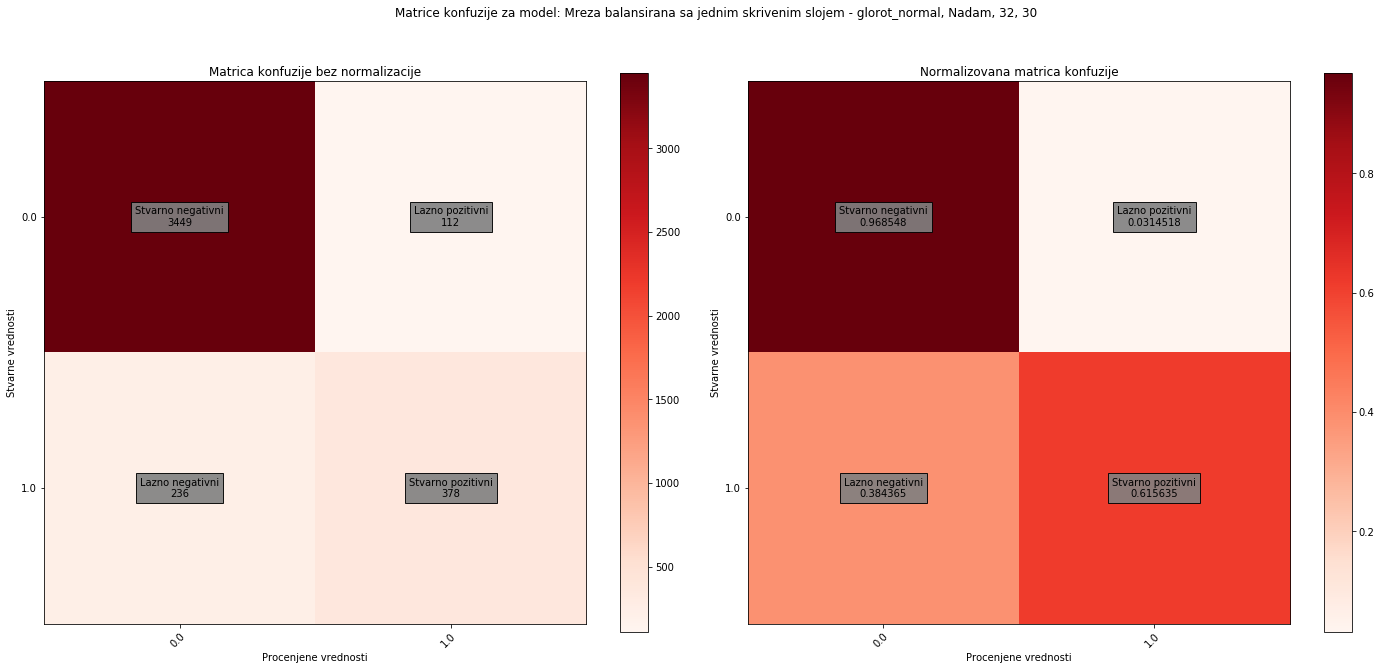

In [ ]:
ime = 'Mreza balansirana sa jednim skrivenim slojem - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()


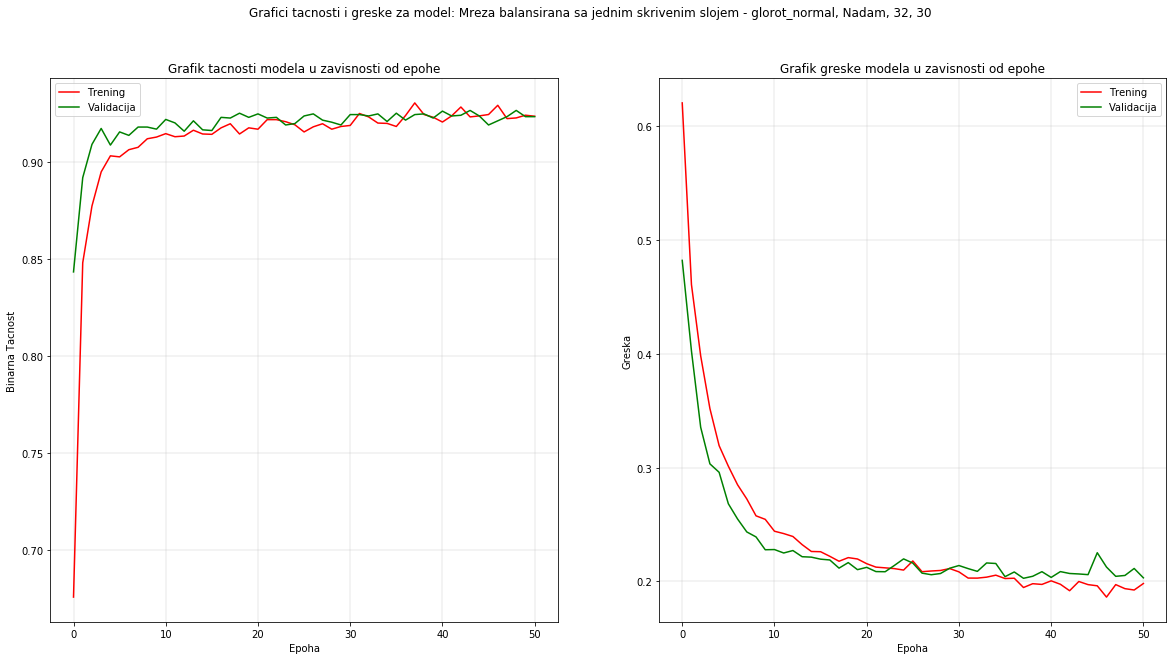

In [ ]:
nacrtaj_ucenje (istorija, ime)


### 3.1.1 Potpuno povezana neuronska mreza sa ukljucenim class_weight parametrom (koji uzima u obzir nebalansiranost klasa pri ucenju) sa dva skrivena sloja


In [ ]:
# Mreza sa dva skrivena sloja
# Vreme izvrsavanja ~ 2h 42 min., 2h
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_2, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1, br_neur_2 = br_neurona_2, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening, y_trening, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi, class_weight = tezine_klasa)
'''

najb_parametri =  nadji_najbolje_parametre (x_trening, y_trening, x_valid, y_valid, x_test, y_test, 2, tezine_klasa)


Ukupan broj prolaza: 72
Novi f1 skor: 0.6935779816513762
Novi f1 skor: 0.7012750455373405
Novi f1 skor: 0.7095022624434388
Prolaz: 18
Novi f1 skor: 0.7132743362831857
Prolaz: 36
Prolaz: 54
Proteklo vreme: 2:00:31.702766
Najbolji parametri:
 {'opt': 'Nadam', 'kern_ini': 'glorot_uniform', 'batch_size': 32, 'br_n_1': 30, 'br_n_2': 13}


In [ ]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur_1 = mreza_2.best_params_['br_neur_1']
najb_br_neur_2 = mreza_2.best_params_['br_neur_2']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona prvog sloja:', najb_br_neur_1)
print ('Broj neurona drugog sloja:', najb_br_neur_2)
'''

najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur_1 = najb_parametri['br_n_1']
najb_br_neur_2 = najb_parametri['br_n_2']


In [ ]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
mreza_bal = napravi_mrezu_2 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur_1, br_neur_2 = najb_br_neur_2)
mreza_bal.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                1290      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
activation_1 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 13)                403       
_________________________________________________________________
batch_normalization_2 (Batch (None, 13)                52        
_________________________________________________________________
activation_2 (Activation)    (None, 13)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
istorija = mreza_bal.fit (x_trening, y_trening, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, class_weight = tezine_klasa, validation_data = (x_valid, y_valid), verbose = 1)


Train on 5678 samples, validate on 2798 samples
Epoch 1/200
5678/5678 [==============================] - 3s 543us/step - loss: 0.5731 - binary_accuracy: 0.7568 - val_loss: 0.4725 - val_binary_accuracy: 0.8674
Epoch 2/200
5678/5678 [==============================] - 2s 389us/step - loss: 0.4513 - binary_accuracy: 0.8545 - val_loss: 0.3798 - val_binary_accuracy: 0.9021
Epoch 3/200
5678/5678 [==============================] - 2s 384us/step - loss: 0.3795 - binary_accuracy: 0.8906 - val_loss: 0.3262 - val_binary_accuracy: 0.9146
Epoch 4/200
5678/5678 [==============================] - 2s 402us/step - loss: 0.3399 - binary_accuracy: 0.8991 - val_loss: 0.2925 - val_binary_accuracy: 0.9171
Epoch 5/200
5678/5678 [==============================] - 2s 388us/step - loss: 0.3107 - binary_accuracy: 0.9035 - val_loss: 0.2712 - val_binary_accuracy: 0.9160
Epoch 6/200
5678/5678 [==============================] - 2s 388us/step - loss: 0.2843 - binary_accuracy: 0.9107 - val_loss: 0.2552 - val_binary_acc

In [ ]:
y_procena = mreza_bal.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije balansirane potpuno povezane mreze sa dva skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))

Izvestaj klasifikacije balansirane potpuno povezane mreze sa dva skrivena sloja:
               precision    recall  f1-score   support

           0       0.94      0.97      0.96      3561
           1       0.81      0.62      0.70       614

    accuracy                           0.92      4175
   macro avg       0.87      0.80      0.83      4175
weighted avg       0.92      0.92      0.92      4175



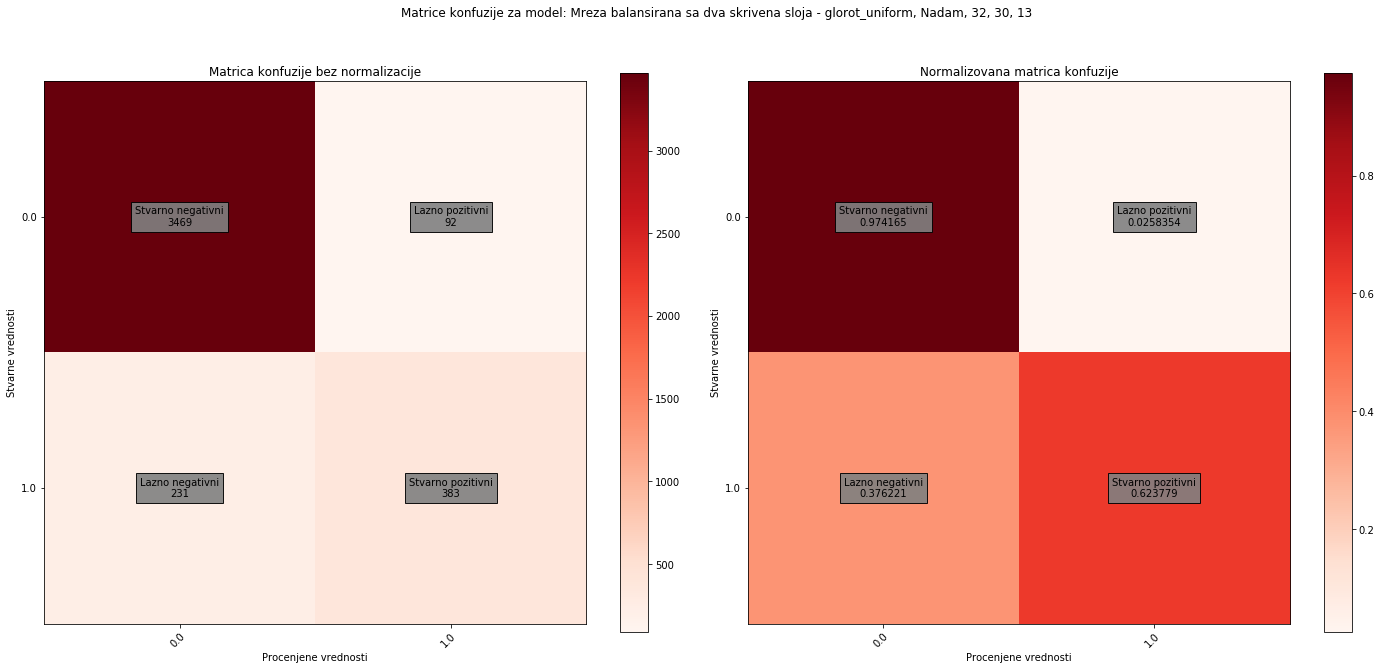

In [ ]:
ime = 'Mreza balansirana sa dva skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()


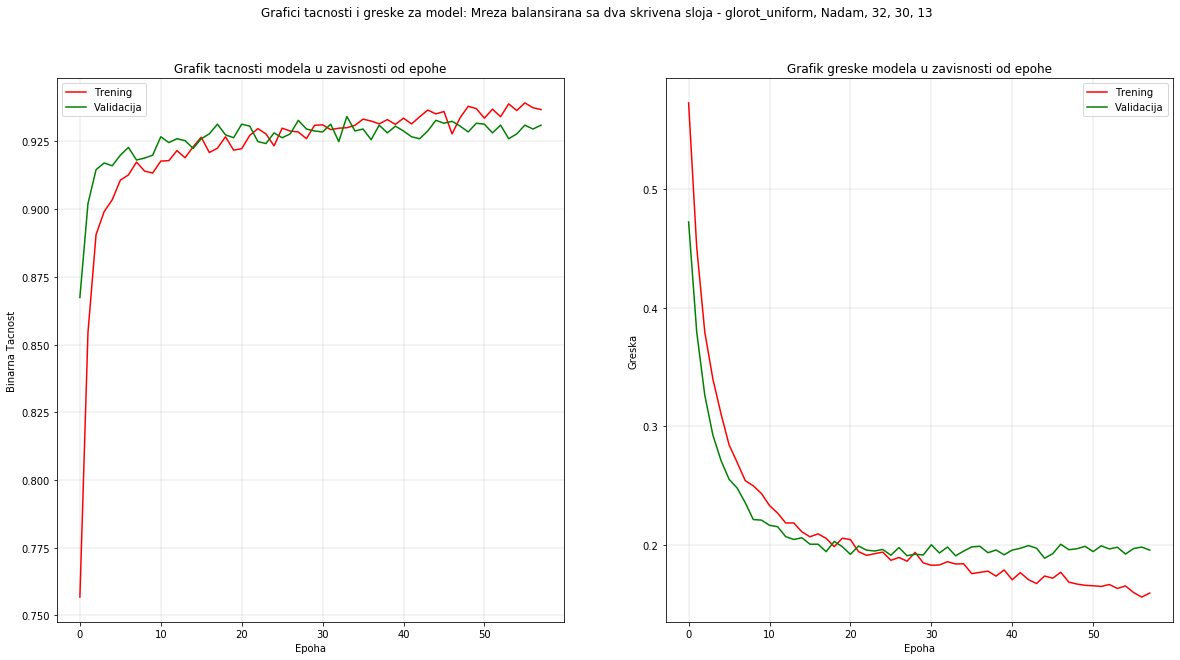

In [ ]:
nacrtaj_ucenje (istorija, ime)


In [ ]:
# Mreza sa tri skrivena sloja
# Vreme izvrsavanja ~ 100 min.
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_3, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1, br_neur_2 = br_neurona_2, br_neur_3 = br_neurona_3, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening, y_trening, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi, class_weight = tezine_klasa)
'''

#najb_parametri =  nadji_najbolje_parametre (x_trening, y_trening, x_valid, y_valid, x_test, y_test, 3, tezine_klasa)


"\nmreza_1 = KerasClassifier (build_fn = napravi_mrezu_3, verbose=0)\n\nparametri = dict (br_neur_1 = br_neurona_1, br_neur_2 = br_neurona_2, br_neur_3 = br_neurona_3, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)\n\nmreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)\nmreza_2.fit (x_trening, y_trening, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi, class_weight = tezine_klasa)\n"

In [ ]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur_1 = mreza_2.best_params_['br_neur_1']
najb_br_neur_2 = mreza_2.best_params_['br_neur_2']
najb_br_neur_3 = mreza_2.best_params_['br_neur_3']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona prvog sloja:', najb_br_neur_1)
print ('Broj neurona drugog sloja:', najb_br_neur_2)
print ('Broj neurona treceg sloja:', najb_br_neur_3)


najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur_1 = najb_parametri['br_n_1']
najb_br_neur_2 = najb_parametri['br_n_2']
najb_br_neur_3 = najb_parametri['br_n_3']
'''

"\nnajb_opt = mreza_2.best_params_['optimizer']\nnajb_inic = mreza_2.best_params_['kernel_initializer']\nnajb_vel = mreza_2.best_params_['batch_size']\nnajb_br_neur_1 = mreza_2.best_params_['br_neur_1']\nnajb_br_neur_2 = mreza_2.best_params_['br_neur_2']\nnajb_br_neur_3 = mreza_2.best_params_['br_neur_3']\n\nprint ('Najbolji parametri mreze su:')\nprint ('Kernel initializer:', najb_inic)\nprint ('Optimizer:', najb_opt)\nprint ('Batch size:', najb_vel)\nprint ('Broj neurona prvog sloja:', najb_br_neur_1)\nprint ('Broj neurona drugog sloja:', najb_br_neur_2)\nprint ('Broj neurona treceg sloja:', najb_br_neur_3)\n\n\nnajb_opt = najb_parametri['opt']\nnajb_inic = najb_parametri['kern_ini']\nnajb_vel = najb_parametri['batch_size']\nnajb_br_neur_1 = najb_parametri['br_n_1']\nnajb_br_neur_2 = najb_parametri['br_n_2']\nnajb_br_neur_3 = najb_parametri['br_n_3']\n"

In [ ]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
#mreza_bal = napravi_mrezu_3 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur_1, br_neur_2 = najb_br_neur_2, br_neur_3 = najb_br_neur_3)
#mreza_bal.summary()


In [ ]:
#istorija = mreza_bal.fit (x_trening, y_trening, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, class_weight = tezine_klasa, validation_data = (x_valid, y_valid), verbose = 1)


In [ ]:
'''
y_procena = mreza_bal.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije balansirane potpuno povezane mreze sa tri skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))
'''

"\ny_procena = mreza_bal.predict(x_test)\ny_procena_zaok = np.rint (y_procena)\n\nprint ('Izvestaj klasifikacije balansirane potpuno povezane mreze sa tri skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))\n"

In [ ]:
'''
ime = 'Mreza balansirana sa tri skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2) + ', ' + str(najb_br_neur_3))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()
'''

"\nime = 'Mreza balansirana sa tri skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2) + ', ' + str(najb_br_neur_3))\nnacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)\nplt.show()\n"

In [ ]:
#nacrtaj_ucenje (istorija, ime)


## 3.2. Polazni skup podataka koji je balansiran nasumicnim podsempliranjem

### 3.2.1 Potpuno povezana neuronska mreza sa jednim skrivenim slojem


In [ ]:
# Ovde se obavlja GridSearch bez scoring parametra (koristi se scoring samog modela)
# To je potrebno jer je broj podataka mali te dolazi do nedefinisane f1 mere
# Vreme izvrsavanja ~ 14 min., 12 min.
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_1, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1 + br_neurona_2, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening_pod, y_trening_pod, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''

najb_parametri =  nadji_najbolje_parametre (x_trening_pod, y_trening_pod, x_valid, y_valid, x_test, y_test, 1)


Ukupan broj prolaza: 24
Novi f1 skor: 0.5892215568862275
Novi f1 skor: 0.5902612826603325
Novi f1 skor: 0.6029055690072639
Prolaz: 6
Prolaz: 12
Prolaz: 18
Proteklo vreme: 0:11:59.238523
Najbolji parametri:
 {'opt': 'Nadam', 'kern_ini': 'he_uniform', 'batch_size': 32, 'br_n_1': 30}


In [ ]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur = mreza_2.best_params_['br_neur_1']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona:', najb_br_neur)
'''

najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur = najb_parametri['br_n_1']


In [ ]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
mreza_pod = napravi_mrezu_1 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur)
mreza_pod.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                1290      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
activation_1 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
_________________________________________________________________
batch_normalization_2 (Batch (None, 1)                 4         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 1,445
Trainable params: 1,383
Non-trainable params: 62
___________________________________________________

In [ ]:
istorija = mreza_pod.fit (x_trening_pod, y_trening_pod, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)


Train on 1670 samples, validate on 2798 samples
Epoch 1/200
1670/1670 [==============================] - 1s 789us/step - loss: 0.6340 - binary_accuracy: 0.6593 - val_loss: 0.5308 - val_binary_accuracy: 0.7659
Epoch 2/200
1670/1670 [==============================] - 1s 395us/step - loss: 0.5219 - binary_accuracy: 0.7659 - val_loss: 0.4698 - val_binary_accuracy: 0.8310
Epoch 3/200
1670/1670 [==============================] - 1s 378us/step - loss: 0.4916 - binary_accuracy: 0.7796 - val_loss: 0.4466 - val_binary_accuracy: 0.8481
Epoch 4/200
1670/1670 [==============================] - 1s 370us/step - loss: 0.4773 - binary_accuracy: 0.7874 - val_loss: 0.4331 - val_binary_accuracy: 0.8563
Epoch 5/200
1670/1670 [==============================] - 1s 377us/step - loss: 0.4550 - binary_accuracy: 0.8024 - val_loss: 0.4217 - val_binary_accuracy: 0.8606
Epoch 6/200
1670/1670 [==============================] - 1s 380us/step - loss: 0.4431 - binary_accuracy: 0.8204 - val_loss: 0.4167 - val_binary_acc

In [ ]:
y_procena = mreza_pod.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije podsemplirane potpuno povezane sa jednim skrivenim slojem mreze:\n', met.classification_report (y_test, y_procena_zaok))

Izvestaj klasifikacije podsemplirane potpuno povezane sa jednim skrivenim slojem mreze:
               precision    recall  f1-score   support

           0       0.96      0.86      0.91      3561
           1       0.50      0.79      0.61       614

    accuracy                           0.85      4175
   macro avg       0.73      0.83      0.76      4175
weighted avg       0.89      0.85      0.86      4175



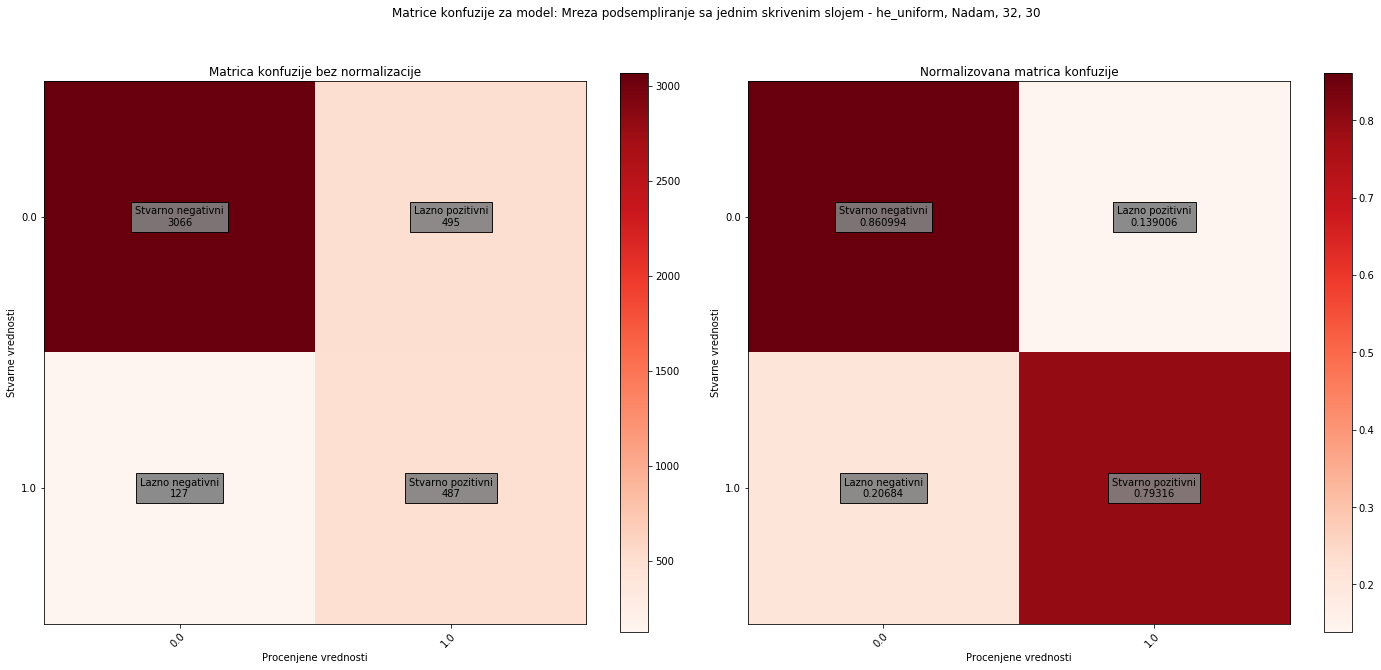

In [ ]:
ime = 'Mreza podsempliranje sa jednim skrivenim slojem - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()


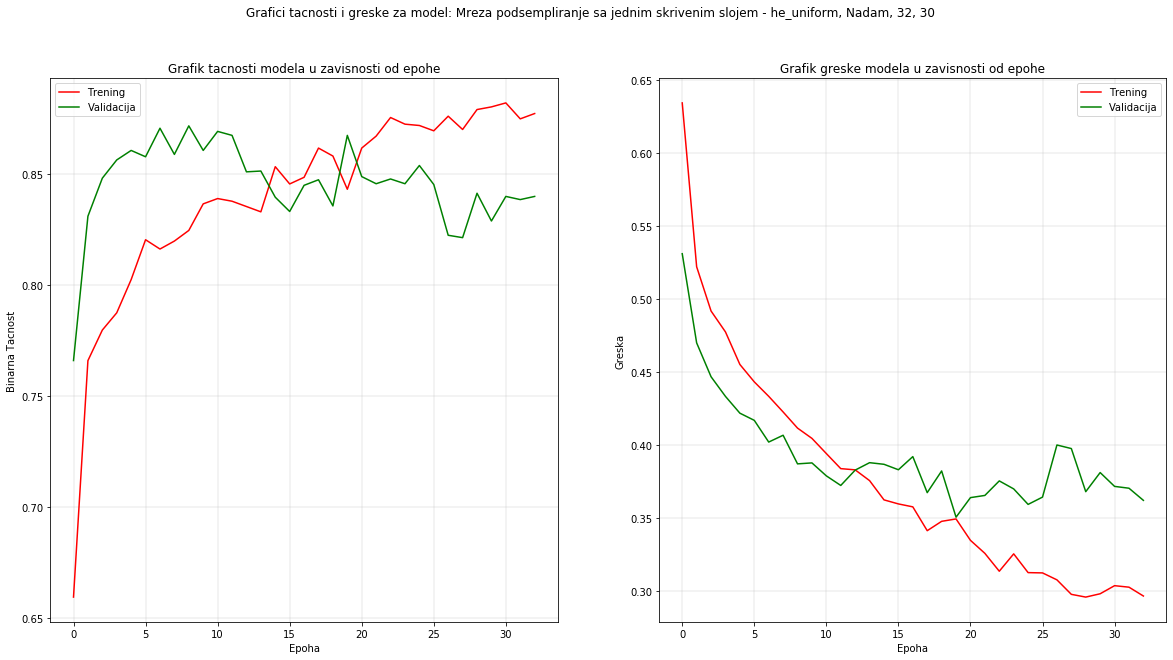

In [ ]:
nacrtaj_ucenje (istorija, ime)


### 3.2.2 Potpuno povezana neuronska mreza sa dva skrivena sloja


In [ ]:
# Mreza sa dva skrivena sloja
# Vreme izvrsavanja ~ 46 min., 40min.
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_2, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1, br_neur_2 = br_neurona_2, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening_pod, y_trening_pod, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''

najb_parametri =  nadji_najbolje_parametre (x_trening_pod, y_trening_pod, x_valid, y_valid, x_test, y_test, 2)


Ukupan broj prolaza: 72
Novi f1 skor: 0.5977286312014346
Novi f1 skor: 0.6100000000000001
Novi f1 skor: 0.6197916666666666
Novi f1 skor: 0.6198608475648323
Prolaz: 18
Prolaz: 36
Prolaz: 54
Novi f1 skor: 0.6222509702457956
Proteklo vreme: 0:40:41.985405
Najbolji parametri:
 {'opt': 'RMSprop', 'kern_ini': 'he_normal', 'batch_size': 32, 'br_n_1': 20, 'br_n_2': 15}


In [ ]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur_1 = mreza_2.best_params_['br_neur_1']
najb_br_neur_2 = mreza_2.best_params_['br_neur_2']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona prvog sloja:', najb_br_neur_1)
print ('Broj neurona drugog sloja:', najb_br_neur_2)
'''

najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur_1 = najb_parametri['br_n_1']
najb_br_neur_2 = najb_parametri['br_n_2']


In [ ]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
mreza_pod = napravi_mrezu_2 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur_1, br_neur_2 = najb_br_neur_2)
mreza_pod.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                860       
_________________________________________________________________
batch_normalization_1 (Batch (None, 20)                80        
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                315       
_________________________________________________________________
batch_normalization_2 (Batch (None, 15)                60        
_________________________________________________________________
activation_2 (Activation)    (None, 15)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
istorija = mreza_pod.fit (x_trening_pod, y_trening_pod, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)


Train on 1670 samples, validate on 2798 samples
Epoch 1/200
1670/1670 [==============================] - 1s 893us/step - loss: 0.6899 - binary_accuracy: 0.6042 - val_loss: 0.5712 - val_binary_accuracy: 0.7573
Epoch 2/200
1670/1670 [==============================] - 1s 444us/step - loss: 0.5653 - binary_accuracy: 0.7186 - val_loss: 0.4893 - val_binary_accuracy: 0.8127
Epoch 3/200
1670/1670 [==============================] - 1s 439us/step - loss: 0.5230 - binary_accuracy: 0.7545 - val_loss: 0.4504 - val_binary_accuracy: 0.8395
Epoch 4/200
1670/1670 [==============================] - 1s 428us/step - loss: 0.5048 - binary_accuracy: 0.7677 - val_loss: 0.4396 - val_binary_accuracy: 0.8549
Epoch 5/200
1670/1670 [==============================] - 1s 443us/step - loss: 0.4878 - binary_accuracy: 0.7868 - val_loss: 0.4246 - val_binary_accuracy: 0.8628
Epoch 6/200
1670/1670 [==============================] - 1s 432us/step - loss: 0.4741 - binary_accuracy: 0.7958 - val_loss: 0.4207 - val_binary_acc

In [ ]:
y_procena = mreza_pod.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije podsemplirane potpuno povezane sa dva skrivena sloja mreze:\n', met.classification_report (y_test, y_procena_zaok))

Izvestaj klasifikacije podsemplirane potpuno povezane sa dva skrivena sloja mreze:
               precision    recall  f1-score   support

           0       0.96      0.87      0.91      3561
           1       0.51      0.80      0.62       614

    accuracy                           0.86      4175
   macro avg       0.73      0.83      0.77      4175
weighted avg       0.89      0.86      0.87      4175



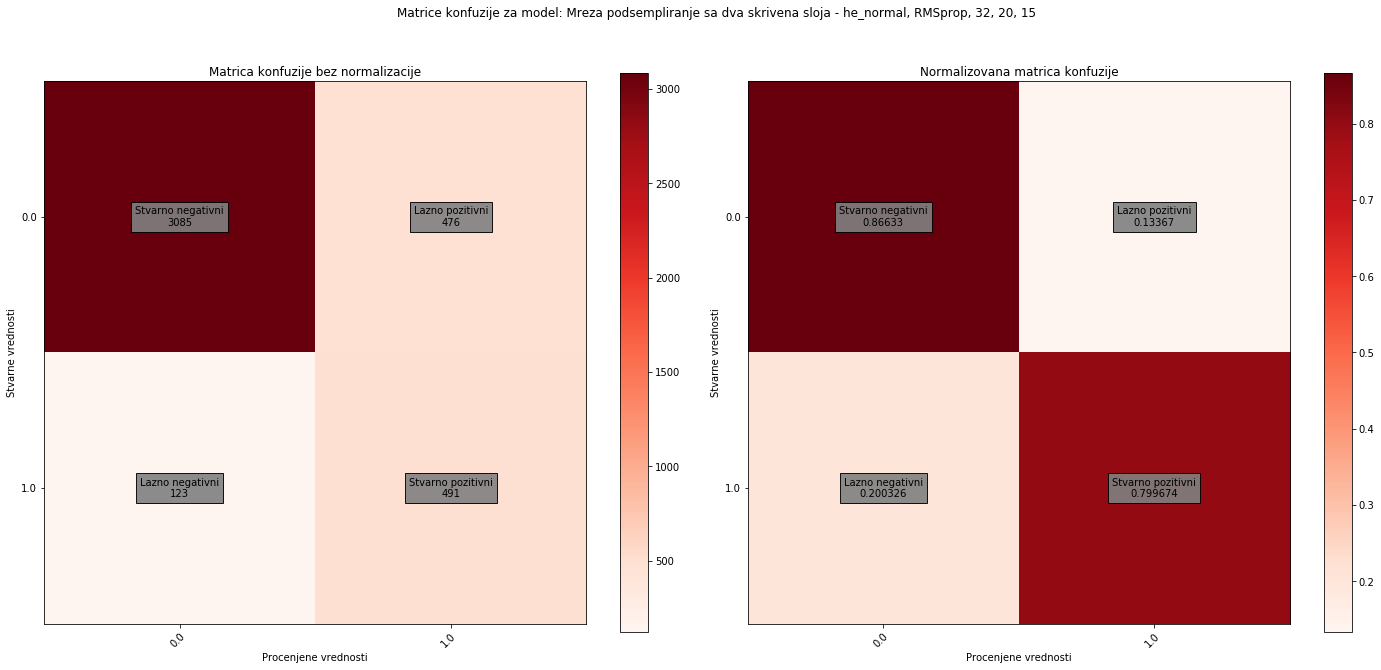

In [ ]:
ime = 'Mreza podsempliranje sa dva skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()


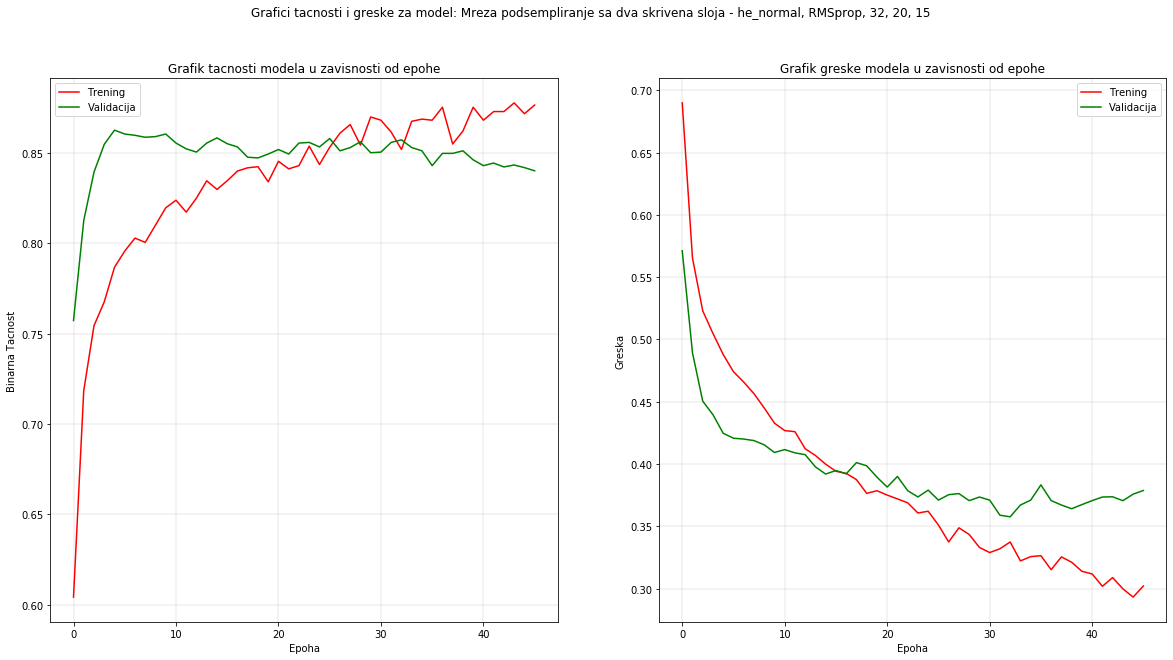

In [ ]:
nacrtaj_ucenje (istorija, ime)


In [ ]:
# Mreza sa tri skrivena sloja
# Vreme izvrsavanja ~ 30 min.
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_3, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1, br_neur_2 = br_neurona_2, br_neur_3 = br_neurona_3, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening_pod, y_trening_pod, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''

#najb_parametri =  nadji_najbolje_parametre (x_trening_pod, y_trening_pod, x_valid, y_valid, x_test, y_test, 3)


'\nmreza_1 = KerasClassifier (build_fn = napravi_mrezu_3, verbose=0)\n\nparametri = dict (br_neur_1 = br_neurona_1, br_neur_2 = br_neurona_2, br_neur_3 = br_neurona_3, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)\n\nmreza_2 = ms.GridSearchCV(estimator = mreza_1, param_grid = parametri, n_jobs = 1, cv = 2, verbose = 1)\nmreza_2.fit (x_trening_pod, y_trening_pod, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)\n'

In [ ]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur_1 = mreza_2.best_params_['br_neur_1']
najb_br_neur_2 = mreza_2.best_params_['br_neur_2']
najb_br_neur_3 = mreza_2.best_params_['br_neur_3']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona prvog sloja:', najb_br_neur_1)
print ('Broj neurona drugog sloja:', najb_br_neur_2)
print ('Broj neurona treceg sloja:', najb_br_neur_3)


najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur_1 = najb_parametri['br_n_1']
najb_br_neur_2 = najb_parametri['br_n_2']
najb_br_neur_3 = najb_parametri['br_n_3']
'''

"\nnajb_opt = mreza_2.best_params_['optimizer']\nnajb_inic = mreza_2.best_params_['kernel_initializer']\nnajb_vel = mreza_2.best_params_['batch_size']\nnajb_br_neur_1 = mreza_2.best_params_['br_neur_1']\nnajb_br_neur_2 = mreza_2.best_params_['br_neur_2']\nnajb_br_neur_3 = mreza_2.best_params_['br_neur_3']\n\nprint ('Najbolji parametri mreze su:')\nprint ('Kernel initializer:', najb_inic)\nprint ('Optimizer:', najb_opt)\nprint ('Batch size:', najb_vel)\nprint ('Broj neurona prvog sloja:', najb_br_neur_1)\nprint ('Broj neurona drugog sloja:', najb_br_neur_2)\nprint ('Broj neurona treceg sloja:', najb_br_neur_3)\n\n\nnajb_opt = najb_parametri['opt']\nnajb_inic = najb_parametri['kern_ini']\nnajb_vel = najb_parametri['batch_size']\nnajb_br_neur_1 = najb_parametri['br_n_1']\nnajb_br_neur_2 = najb_parametri['br_n_2']\nnajb_br_neur_3 = najb_parametri['br_n_3']\n"

In [ ]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
#mreza_pod = napravi_mrezu_3 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur_1, br_neur_2 = najb_br_neur_2, br_neur_3 = najb_br_neur_3)
#mreza_pod.summary()


In [ ]:
#istorija = mreza_pod.fit (x_trening_pod, y_trening_pod, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)


In [ ]:
'''
y_procena = mreza_pod.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije podsemplirane potpuno povezane sa tri skrivena sloja mreze:\n', met.classification_report (y_test, y_procena_zaok))
'''

"\ny_procena = mreza_pod.predict(x_test)\ny_procena_zaok = np.rint (y_procena)\n\nprint ('Izvestaj klasifikacije podsemplirane potpuno povezane sa tri skrivena sloja mreze:\n', met.classification_report (y_test, y_procena_zaok))\n"

In [ ]:
'''
ime = 'Mreza podsempliranje sa tri skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2) + ', ' + str(najb_br_neur_3))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()
'''


"\nime = 'Mreza podsempliranje sa tri skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2) + ', ' + str(najb_br_neur_3))\nnacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)\nplt.show()\n"

In [ ]:
#nacrtaj_ucenje (istorija, ime)


## 3.3. Polazni skup podataka koji je balansiran SMOTE nadsempliranjem

### 3.3.1 Potpuno povezana neuronska mreza sa jednim skrivenim slojem

In [ ]:
# Mreza sa jednim skrivenim slojem
# Vreme izvrsavanja ~ 46 min., 35 min.
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_1, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1 + br_neurona_2, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV (estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening_nad_smote, y_trening_nad_smote, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''

najb_parametri =  nadji_najbolje_parametre (x_trening_nad_smote, y_trening_nad_smote, x_valid, y_valid, x_test, y_test, 1)


Ukupan broj prolaza: 24
Novi f1 skor: 0.6694444444444444
Prolaz: 6
Novi f1 skor: 0.6718528995756718
Prolaz: 12
Prolaz: 18
Proteklo vreme: 0:35:57.206263
Najbolji parametri:
 {'opt': 'RMSprop', 'kern_ini': 'he_normal', 'batch_size': 32, 'br_n_1': 25}


In [ ]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur = mreza_2.best_params_['br_neur_1']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona:', najb_br_neur)
'''

najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur = najb_parametri['br_n_1']


In [ ]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
mreza_nad_smote = napravi_mrezu_1 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur)
mreza_nad_smote.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                1075      
_________________________________________________________________
batch_normalization_1 (Batch (None, 25)                100       
_________________________________________________________________
activation_1 (Activation)    (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 26        
_________________________________________________________________
batch_normalization_2 (Batch (None, 1)                 4         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 1,205
Trainable params: 1,153
Non-trainable params: 52
___________________________________________________

In [ ]:
istorija = mreza_nad_smote.fit (x_trening_nad_smote, y_trening_nad_smote, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)


Train on 9686 samples, validate on 2798 samples
Epoch 1/200
9686/9686 [==============================] - 3s 320us/step - loss: 0.5346 - binary_accuracy: 0.7382 - val_loss: 0.4064 - val_binary_accuracy: 0.8674
Epoch 2/200
9686/9686 [==============================] - 3s 259us/step - loss: 0.4358 - binary_accuracy: 0.8255 - val_loss: 0.3628 - val_binary_accuracy: 0.8867
Epoch 3/200
9686/9686 [==============================] - 3s 260us/step - loss: 0.3946 - binary_accuracy: 0.8437 - val_loss: 0.3537 - val_binary_accuracy: 0.8799
Epoch 4/200
9686/9686 [==============================] - 3s 263us/step - loss: 0.3691 - binary_accuracy: 0.8526 - val_loss: 0.3523 - val_binary_accuracy: 0.8656
Epoch 5/200
9686/9686 [==============================] - 3s 285us/step - loss: 0.3510 - binary_accuracy: 0.8571 - val_loss: 0.3280 - val_binary_accuracy: 0.8738
Epoch 6/200
9686/9686 [==============================] - 3s 283us/step - loss: 0.3356 - binary_accuracy: 0.8653 - val_loss: 0.3161 - val_binary_acc

In [ ]:
y_procena = mreza_nad_smote.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije SMOTE nadsemplirane potpuno povezane mreze sa jednim skrivenim slojem:\n', met.classification_report (y_test, y_procena_zaok))

Izvestaj klasifikacije SMOTE nadsemplirane potpuno povezane mreze sa jednim skrivenim slojem:
               precision    recall  f1-score   support

           0       0.96      0.89      0.92      3561
           1       0.55      0.76      0.64       614

    accuracy                           0.87      4175
   macro avg       0.76      0.83      0.78      4175
weighted avg       0.90      0.87      0.88      4175



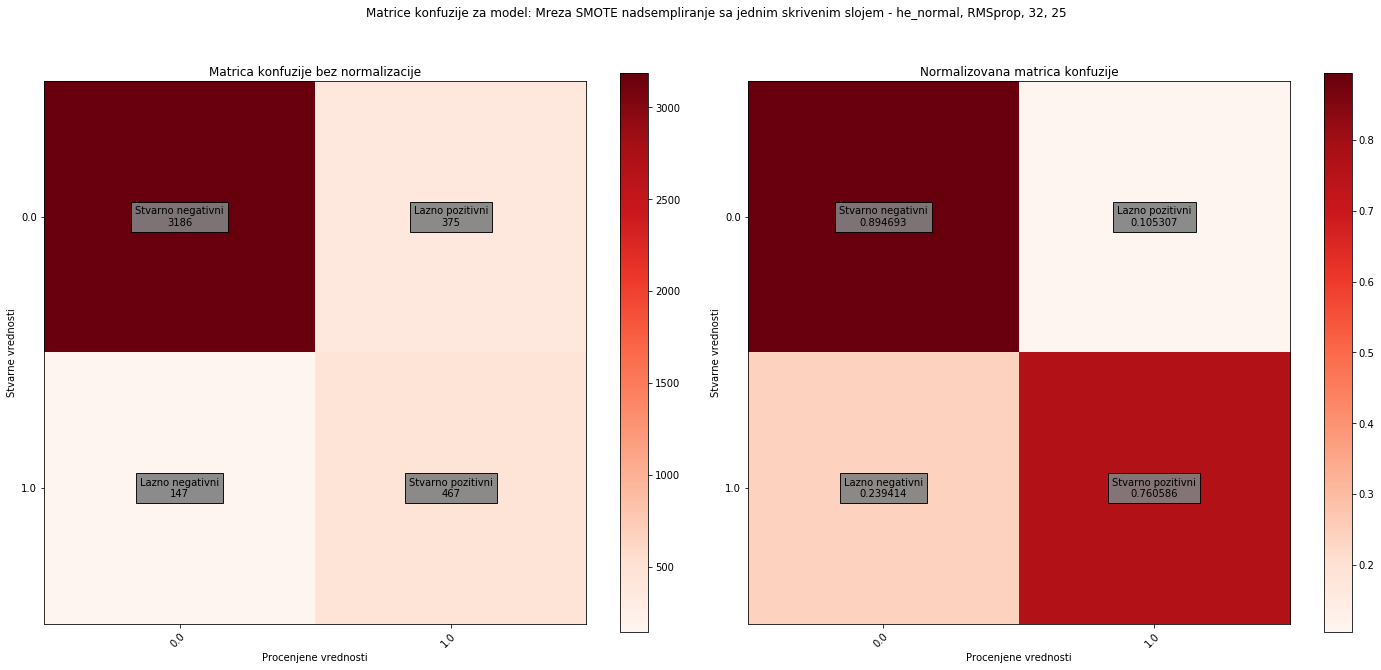

In [ ]:
ime = 'Mreza SMOTE nadsempliranje sa jednim skrivenim slojem - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()


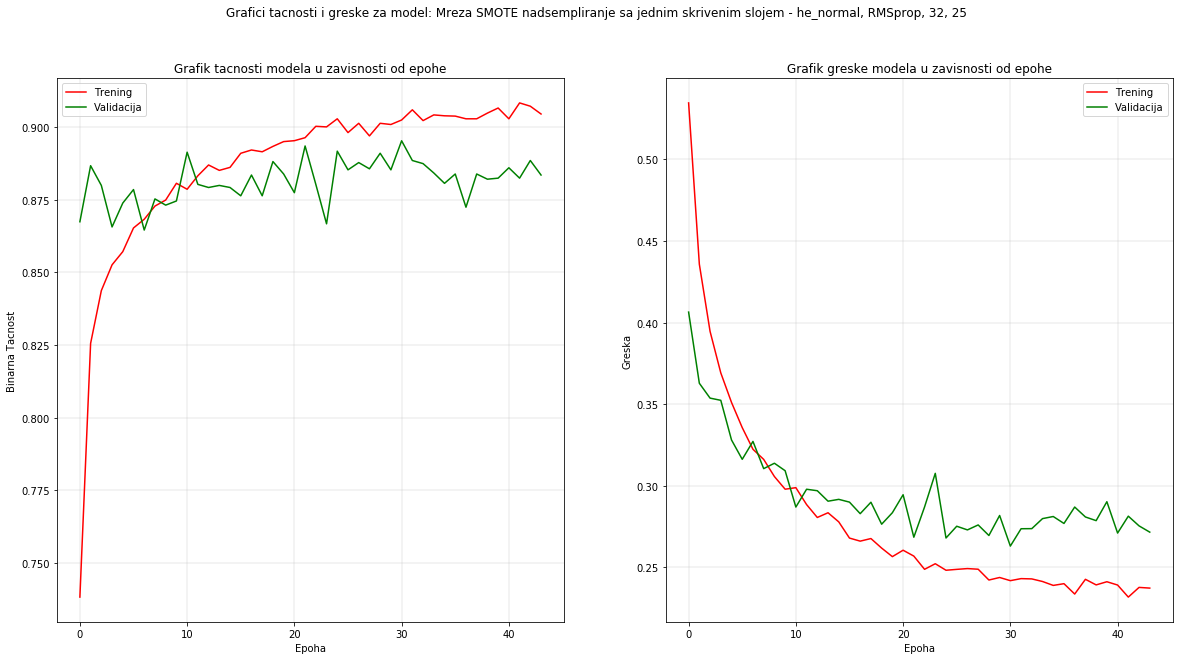

In [ ]:
nacrtaj_ucenje (istorija, ime)


### 3.3.2 Potpuno povezana neuronska mreza sa dva skrivena sloja


In [ ]:
# Mreza sa dva skrivena sloja
# Vreme izvrsavanja ~ 2h 40 min., 2h
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_2, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1, br_neur_2 = br_neurona_2, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV (estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening_nad_smote, y_trening_nad_smote, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''

najb_parametri =  nadji_najbolje_parametre (x_trening_nad_smote, y_trening_nad_smote, x_valid, y_valid, x_test, y_test, 2)


Ukupan broj prolaza: 72
Novi f1 skor: 0.6666666666666666
Novi f1 skor: 0.6808510638297872
Novi f1 skor: 0.6827133479212253
Novi f1 skor: 0.6902255639097744
Prolaz: 18
Novi f1 skor: 0.6914498141263941
Novi f1 skor: 0.6984363365599404
Prolaz: 36
Prolaz: 54
Proteklo vreme: 2:08:21.471192
Najbolji parametri:
 {'opt': 'RMSprop', 'kern_ini': 'glorot_normal', 'batch_size': 32, 'br_n_1': 25, 'br_n_2': 15}


In [ ]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur_1 = mreza_2.best_params_['br_neur_1']
najb_br_neur_2 = mreza_2.best_params_['br_neur_2']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona prvog sloja:', najb_br_neur_1)
print ('Broj neurona drugog sloja:', najb_br_neur_2)
'''

najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur_1 = najb_parametri['br_n_1']
najb_br_neur_2 = najb_parametri['br_n_2']


In [ ]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
mreza_nad_smote = napravi_mrezu_2 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur_1, br_neur_2 = najb_br_neur_2)
mreza_nad_smote.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 25)                1075      
_________________________________________________________________
batch_normalization_1 (Batch (None, 25)                100       
_________________________________________________________________
activation_1 (Activation)    (None, 25)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 15)                390       
_________________________________________________________________
batch_normalization_2 (Batch (None, 15)                60        
_________________________________________________________________
activation_2 (Activation)    (None, 15)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
istorija = mreza_nad_smote.fit (x_trening_nad_smote, y_trening_nad_smote, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)


Train on 9686 samples, validate on 2798 samples
Epoch 1/200
9686/9686 [==============================] - 4s 393us/step - loss: 0.4759 - binary_accuracy: 0.7926 - val_loss: 0.4189 - val_binary_accuracy: 0.8574
Epoch 2/200
9686/9686 [==============================] - 3s 321us/step - loss: 0.4047 - binary_accuracy: 0.8451 - val_loss: 0.3871 - val_binary_accuracy: 0.8645
Epoch 3/200
9686/9686 [==============================] - 3s 322us/step - loss: 0.3679 - binary_accuracy: 0.8563 - val_loss: 0.3500 - val_binary_accuracy: 0.8728
Epoch 4/200
9686/9686 [==============================] - 3s 326us/step - loss: 0.3378 - binary_accuracy: 0.8663 - val_loss: 0.3429 - val_binary_accuracy: 0.8649
Epoch 5/200
9686/9686 [==============================] - 3s 324us/step - loss: 0.3194 - binary_accuracy: 0.8711 - val_loss: 0.3050 - val_binary_accuracy: 0.8778
Epoch 6/200
9686/9686 [==============================] - 3s 324us/step - loss: 0.3055 - binary_accuracy: 0.8784 - val_loss: 0.3236 - val_binary_acc

In [ ]:
y_procena = mreza_nad_smote.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije SMOTE nadsemplirane potpuno povezane mreze sa dva skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))

Izvestaj klasifikacije SMOTE nadsemplirane potpuno povezane mreze sa dva skrivena sloja:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      3561
           1       0.57      0.79      0.66       614

    accuracy                           0.88      4175
   macro avg       0.77      0.84      0.80      4175
weighted avg       0.90      0.88      0.89      4175



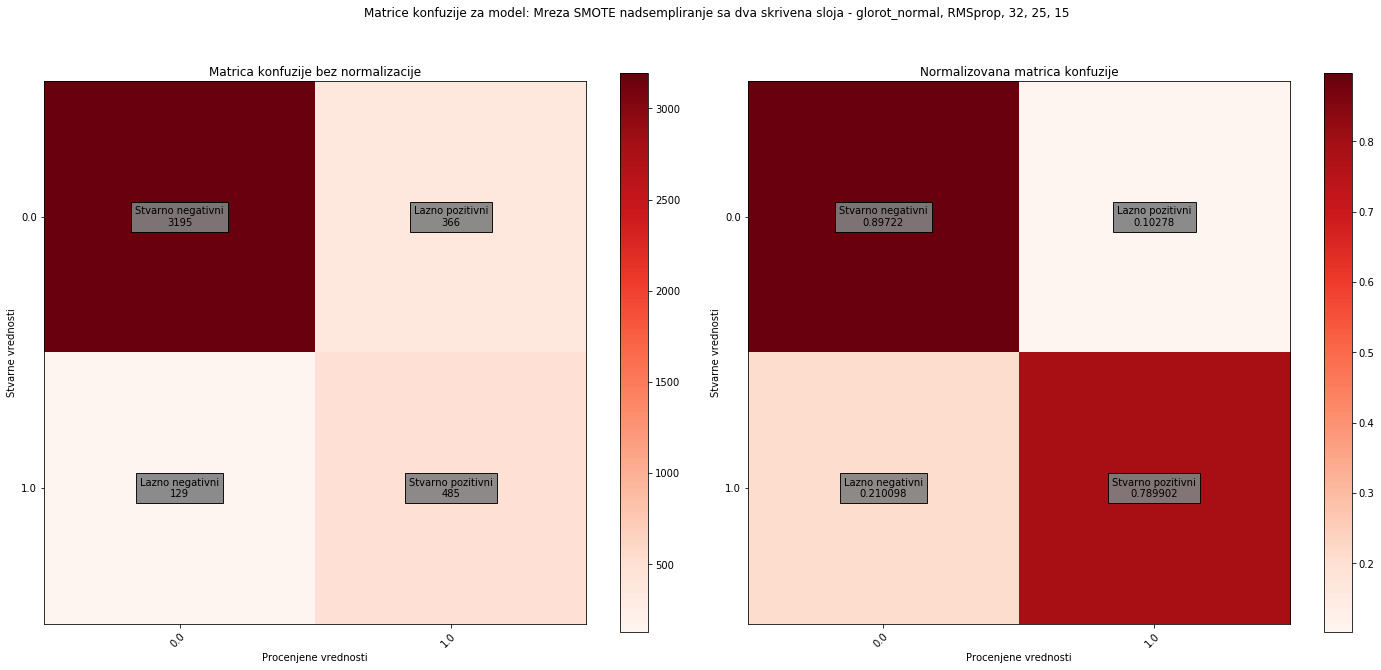

In [ ]:
ime = 'Mreza SMOTE nadsempliranje sa dva skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()


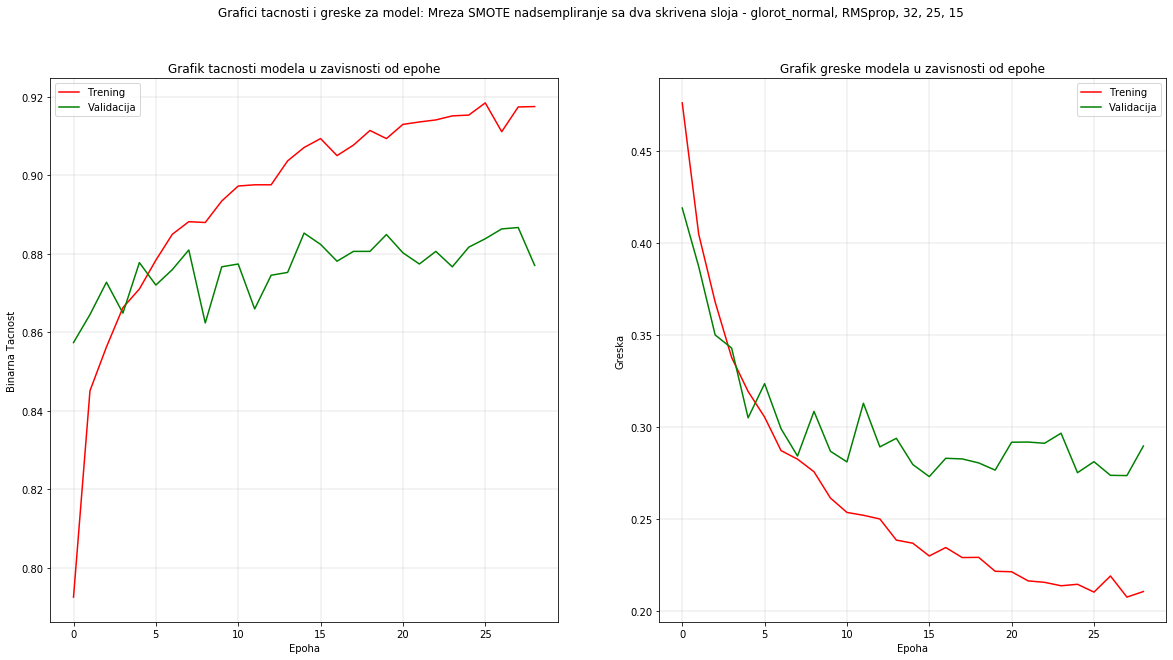

In [ ]:
nacrtaj_ucenje (istorija, ime)


In [ ]:
# Mreza sa tri skrivena sloja
# Vreme izvrsavanja ~  min.
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_3, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1, br_neur_2 = br_neurona_2, br_neur_3 = br_neurona_3, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV (estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening_nad_smote, y_trening_nad_smote, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''

#najb_parametri =  nadji_najbolje_parametre (x_trening_nad_smote, y_trening_nad_smote, x_valid, y_valid, x_test, y_test, 3)


"\nmreza_1 = KerasClassifier (build_fn = napravi_mrezu_3, verbose=0)\n\nparametri = dict (br_neur_1 = br_neurona_1, br_neur_2 = br_neurona_2, br_neur_3 = br_neurona_3, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)\n\nmreza_2 = ms.GridSearchCV (estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)\nmreza_2.fit (x_trening_nad_smote, y_trening_nad_smote, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)\n"

In [ ]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur_1 = mreza_2.best_params_['br_neur_1']
najb_br_neur_2 = mreza_2.best_params_['br_neur_2']
najb_br_neur_3 = mreza_2.best_params_['br_neur_3']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona prvog sloja:', najb_br_neur_1)
print ('Broj neurona drugog sloja:', najb_br_neur_2)
print ('Broj neurona treceg sloja:', najb_br_neur_3)


najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur_1 = najb_parametri['br_n_1']
najb_br_neur_2 = najb_parametri['br_n_2']
najb_br_neur_3 = najb_parametri['br_n_3']
'''

"\nnajb_opt = mreza_2.best_params_['optimizer']\nnajb_inic = mreza_2.best_params_['kernel_initializer']\nnajb_vel = mreza_2.best_params_['batch_size']\nnajb_br_neur_1 = mreza_2.best_params_['br_neur_1']\nnajb_br_neur_2 = mreza_2.best_params_['br_neur_2']\nnajb_br_neur_3 = mreza_2.best_params_['br_neur_3']\n\nprint ('Najbolji parametri mreze su:')\nprint ('Kernel initializer:', najb_inic)\nprint ('Optimizer:', najb_opt)\nprint ('Batch size:', najb_vel)\nprint ('Broj neurona prvog sloja:', najb_br_neur_1)\nprint ('Broj neurona drugog sloja:', najb_br_neur_2)\nprint ('Broj neurona treceg sloja:', najb_br_neur_3)\n\n\nnajb_opt = najb_parametri['opt']\nnajb_inic = najb_parametri['kern_ini']\nnajb_vel = najb_parametri['batch_size']\nnajb_br_neur_1 = najb_parametri['br_n_1']\nnajb_br_neur_2 = najb_parametri['br_n_2']\nnajb_br_neur_3 = najb_parametri['br_n_3']\n"

In [ ]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
#mreza_nad_smote = napravi_mrezu_3 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur_1, br_neur_2 = najb_br_neur_2, br_neur_3 = najb_br_neur_3)
#mreza_nad_smote.summary()


In [ ]:
#istorija = mreza_nad_smote.fit (x_trening_nad_smote, y_trening_nad_smote, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)


In [ ]:
'''
y_procena = mreza_nad_smote.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije SMOTE nadsemplirane potpuno povezane mreze sa tri skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))
'''

"\ny_procena = mreza_nad_smote.predict(x_test)\ny_procena_zaok = np.rint (y_procena)\n\nprint ('Izvestaj klasifikacije SMOTE nadsemplirane potpuno povezane mreze sa tri skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))\n"

In [ ]:
'''
ime = 'Mreza SMOTE nadsempliranje sa tri skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2) + ', ' + str(najb_br_neur_3))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()
'''

"\nime = 'Mreza SMOTE nadsempliranje sa tri skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2) + ', ' + str(najb_br_neur_3))\nnacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)\nplt.show()\n"

In [ ]:
#nacrtaj_ucenje (istorija, ime)


## 3.4. Polazni skup podataka koji je balansiran ADASYN nadsempliranjem

### 3.4.1 Potpuno povezana neuronska mreza sa jednim skrivenim slojem

In [ ]:
# Mreza sa jednim skrivenim slojem
# Vreme izvrsavanja ~ 50 min., 35 min.
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_1, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1 + br_neurona_2, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV (estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening_nad_adasyn, y_trening_nad_adasyn, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''

najb_parametri =  nadji_najbolje_parametre (x_trening_nad_adasyn, y_trening_nad_adasyn, x_valid, y_valid, x_test, y_test, 1)


Ukupan broj prolaza: 24
Novi f1 skor: 0.6182519280205656
Novi f1 skor: 0.6219035202086048
Novi f1 skor: 0.6237688772160209
Novi f1 skor: 0.6298044504383007
Prolaz: 6
Novi f1 skor: 0.637482900136799
Prolaz: 12
Prolaz: 18
Proteklo vreme: 0:35:19.852793
Najbolji parametri:
 {'opt': 'Nadam', 'kern_ini': 'glorot_normal', 'batch_size': 32, 'br_n_1': 30}


In [ ]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur = mreza_2.best_params_['br_neur_1']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona:', najb_br_neur)
'''

najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur = najb_parametri['br_n_1']


In [ ]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
mreza_nad_adasyn = napravi_mrezu_1 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur)
mreza_nad_adasyn.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                1290      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
activation_1 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 31        
_________________________________________________________________
batch_normalization_2 (Batch (None, 1)                 4         
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 1,445
Trainable params: 1,383
Non-trainable params: 62
___________________________________________________

In [ ]:
istorija = mreza_nad_adasyn.fit (x_trening_nad_adasyn, y_trening_nad_adasyn, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)


Train on 9752 samples, validate on 2798 samples
Epoch 1/200
9752/9752 [==============================] - 3s 352us/step - loss: 0.5396 - binary_accuracy: 0.7475 - val_loss: 0.3785 - val_binary_accuracy: 0.8617
Epoch 2/200
9752/9752 [==============================] - 3s 297us/step - loss: 0.4485 - binary_accuracy: 0.8050 - val_loss: 0.3738 - val_binary_accuracy: 0.8442
Epoch 3/200
9752/9752 [==============================] - 3s 282us/step - loss: 0.4078 - binary_accuracy: 0.8265 - val_loss: 0.4046 - val_binary_accuracy: 0.8106
Epoch 4/200
9752/9752 [==============================] - 3s 294us/step - loss: 0.3795 - binary_accuracy: 0.8395 - val_loss: 0.3371 - val_binary_accuracy: 0.8524
Epoch 5/200
9752/9752 [==============================] - 3s 295us/step - loss: 0.3549 - binary_accuracy: 0.8541 - val_loss: 0.3507 - val_binary_accuracy: 0.8413
Epoch 6/200
9752/9752 [==============================] - 3s 280us/step - loss: 0.3454 - binary_accuracy: 0.8551 - val_loss: 0.3386 - val_binary_acc

In [ ]:
y_procena = mreza_nad_adasyn.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije ADASYN nadsemplirane potpuno povezane mreze sa jednim skrivenim slojem:\n', met.classification_report (y_test, y_procena_zaok))

Izvestaj klasifikacije ADASYN nadsemplirane potpuno povezane mreze sa jednim skrivenim slojem:
               precision    recall  f1-score   support

           0       0.96      0.87      0.91      3561
           1       0.51      0.76      0.61       614

    accuracy                           0.86      4175
   macro avg       0.73      0.82      0.76      4175
weighted avg       0.89      0.86      0.87      4175



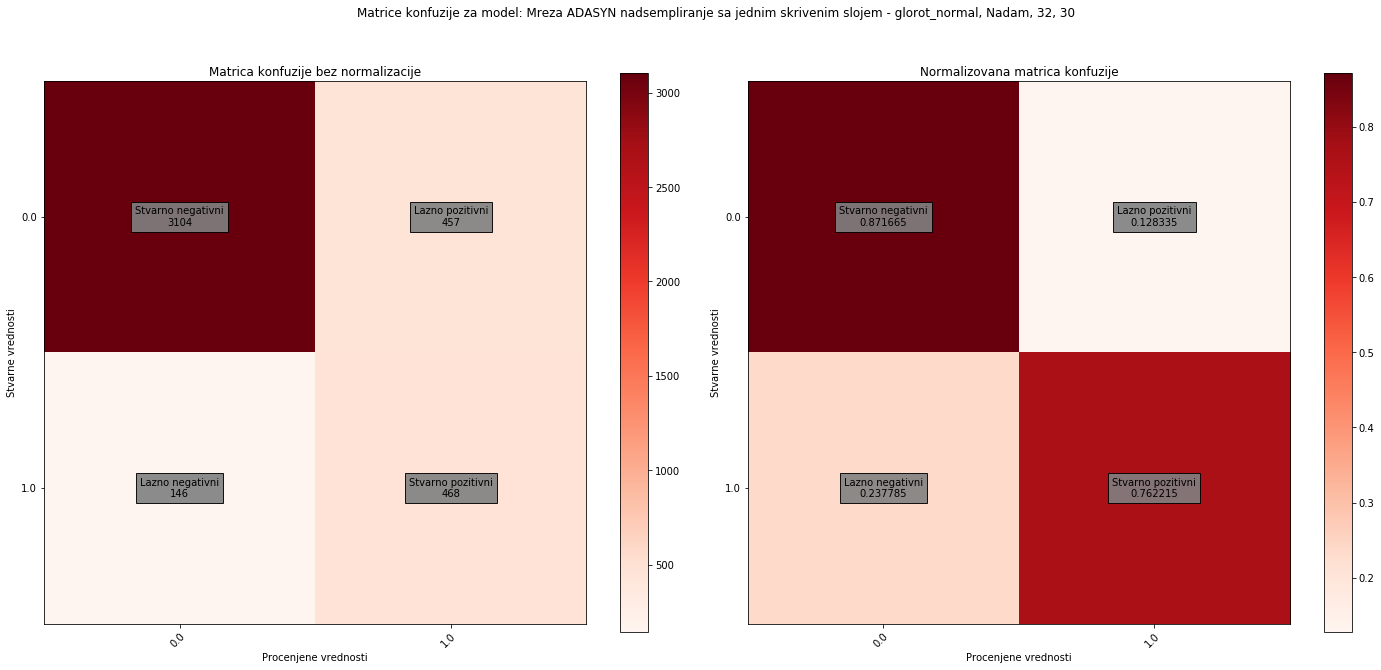

In [ ]:
ime = 'Mreza ADASYN nadsempliranje sa jednim skrivenim slojem - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()


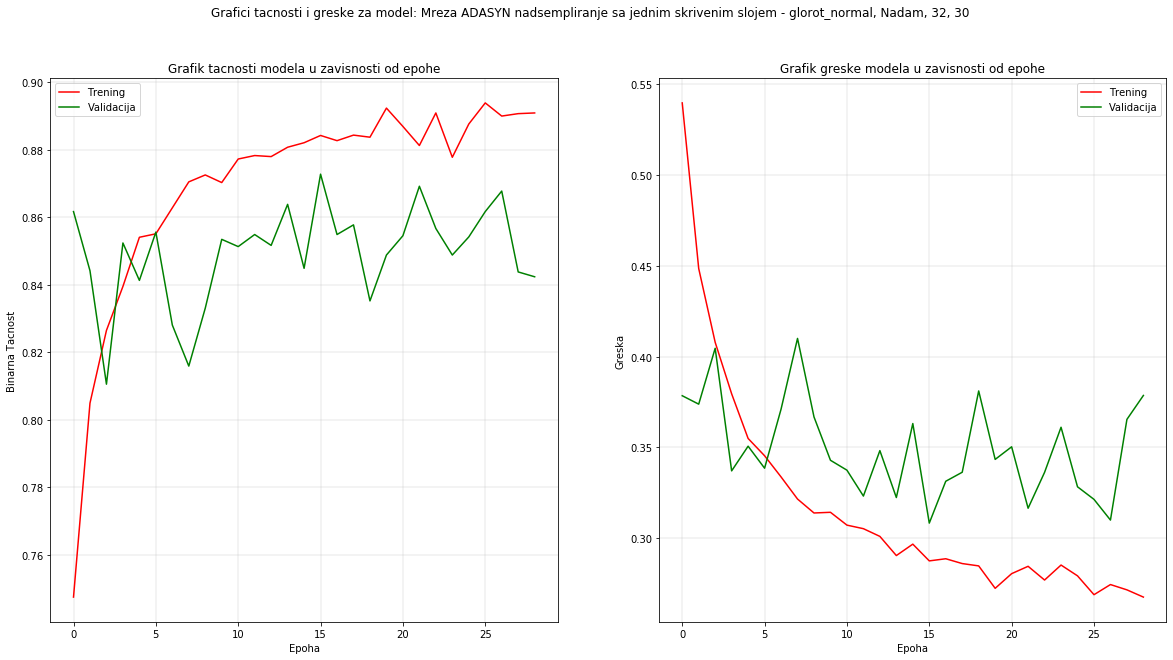

In [ ]:
nacrtaj_ucenje (istorija, ime)


### 3.4.2 Potpuno povezana neuronska mreza sa dva skrivena sloja


In [ ]:
# Mreza sa dva skrivena sloja
# Vreme izvrsavanja ~ 3h, 2h
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_2, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1, br_neur_2 = br_neurona_2, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV (estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening_nad_adasyn, y_trening_nad_adasyn, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''

najb_parametri =  nadji_najbolje_parametre (x_trening_nad_adasyn, y_trening_nad_adasyn, x_valid, y_valid, x_test, y_test, 2)


Ukupan broj prolaza: 72








Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where








Novi f1 skor: 0.6283783783783784
Novi f1 skor: 0.6514837819185645
Novi f1 skor: 0.6642703091301222
Prolaz: 18
Prolaz: 36
Prolaz: 54
Proteklo vreme: 1:59:32.165505
Najbolji parametri:
 {'opt': 'Nadam', 'kern_ini': 'glorot_uniform', 'batch_size': 32, 'br_n_1': 30, 'br_n_2': 18}


In [ ]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur_1 = mreza_2.best_params_['br_neur_1']
najb_br_neur_2 = mreza_2.best_params_['br_neur_2']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona prvog sloja:', najb_br_neur_1)
print ('Broj neurona drugog sloja:', najb_br_neur_2)
'''

najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur_1 = najb_parametri['br_n_1']
najb_br_neur_2 = najb_parametri['br_n_2']


In [ ]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
mreza_nad_adasyn = napravi_mrezu_2 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur_1, br_neur_2 = najb_br_neur_2)
mreza_nad_adasyn.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                1290      
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
activation_1 (Activation)    (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 18)                558       
_________________________________________________________________
batch_normalization_2 (Batch (None, 18)                72        
_________________________________________________________________
activation_2 (Activation)    (None, 18)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [ ]:
istorija = mreza_nad_adasyn.fit (x_trening_nad_adasyn, y_trening_nad_adasyn, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)


Train on 9745 samples, validate on 2798 samples
Epoch 1/200
9745/9745 [==============================] - 4s 452us/step - loss: 0.5062 - binary_accuracy: 0.7708 - val_loss: 0.4440 - val_binary_accuracy: 0.8088
Epoch 2/200
9745/9745 [==============================] - 4s 371us/step - loss: 0.3918 - binary_accuracy: 0.8419 - val_loss: 0.3665 - val_binary_accuracy: 0.8335
Epoch 3/200
9745/9745 [==============================] - 4s 365us/step - loss: 0.3400 - binary_accuracy: 0.8689 - val_loss: 0.3794 - val_binary_accuracy: 0.8363
Epoch 4/200
9745/9745 [==============================] - 4s 369us/step - loss: 0.3046 - binary_accuracy: 0.8845 - val_loss: 0.3558 - val_binary_accuracy: 0.8463
Epoch 5/200
9745/9745 [==============================] - 4s 369us/step - loss: 0.2806 - binary_accuracy: 0.8957 - val_loss: 0.3080 - val_binary_accuracy: 0.8735
Epoch 6/200
9745/9745 [==============================] - 4s 363us/step - loss: 0.2709 - binary_accuracy: 0.8974 - val_loss: 0.3265 - val_binary_acc

In [ ]:
y_procena = mreza_nad_adasyn.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije ADASYN nadsemplirane potpuno povezane mreze sa dva skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))

Izvestaj klasifikacije ADASYN nadsemplirane potpuno povezane mreze sa dva skrivena sloja:
               precision    recall  f1-score   support

           0       0.96      0.90      0.93      3561
           1       0.56      0.77      0.65       614

    accuracy                           0.88      4175
   macro avg       0.76      0.83      0.79      4175
weighted avg       0.90      0.88      0.88      4175



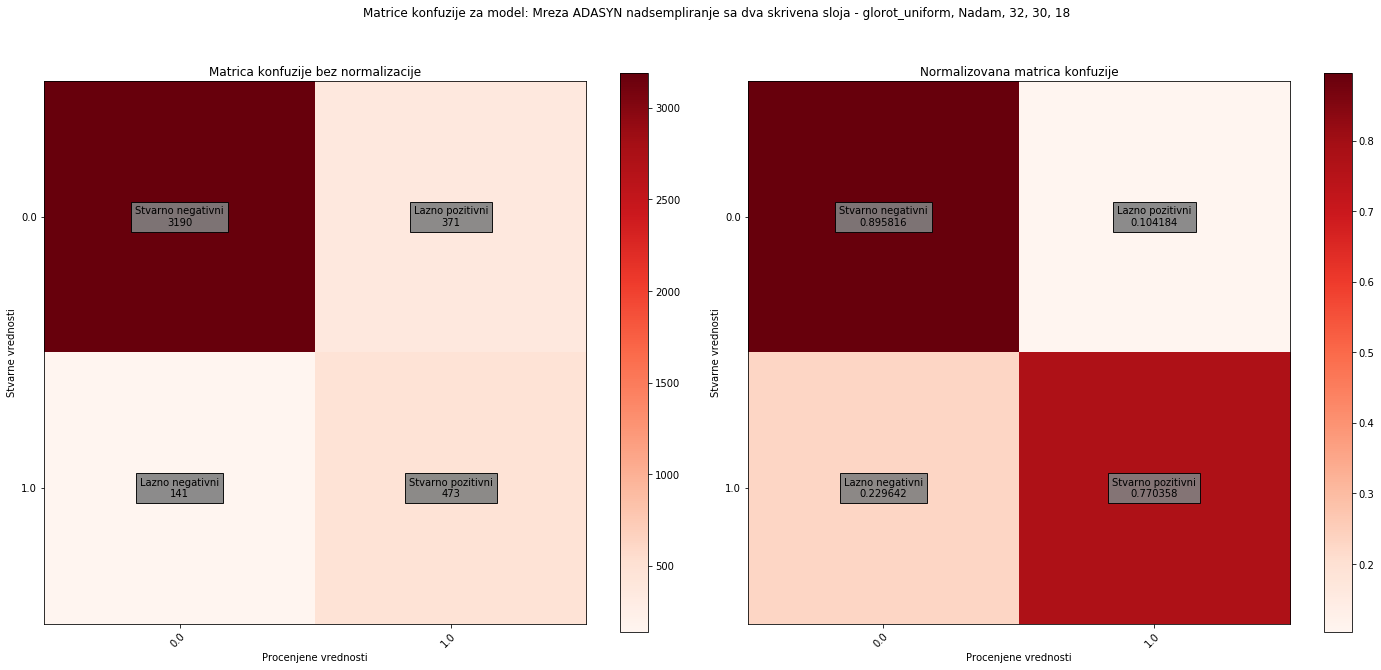

In [ ]:
ime = 'Mreza ADASYN nadsempliranje sa dva skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()


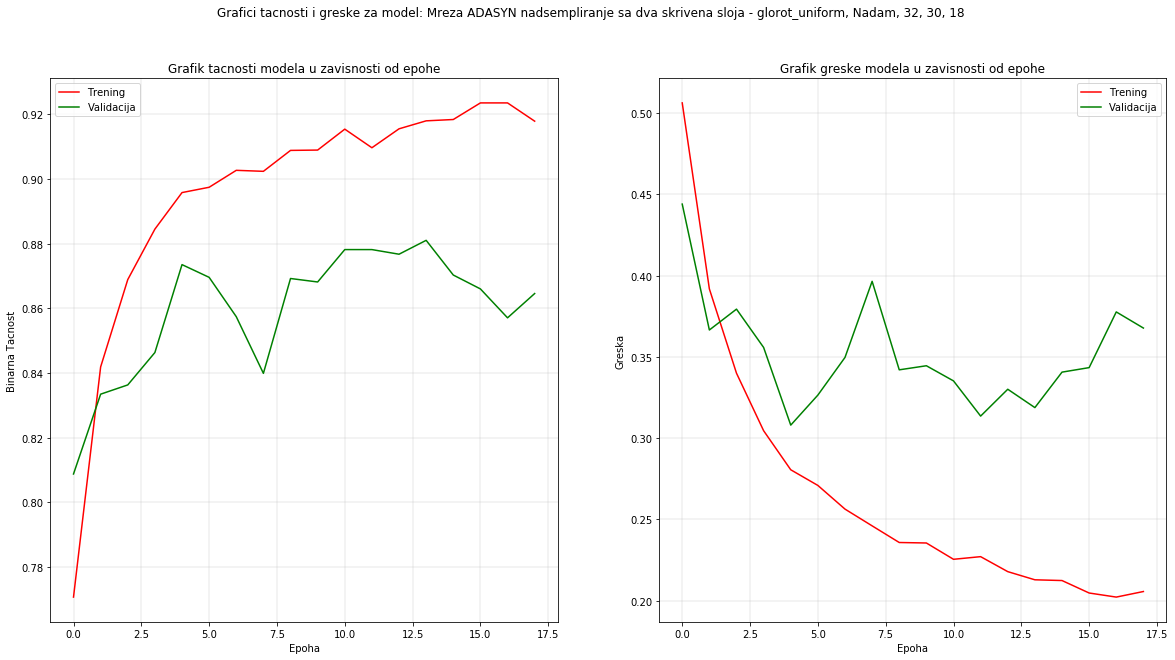

In [ ]:
nacrtaj_ucenje (istorija, ime)


In [ ]:
# Mreza sa tri skrivena sloja
# Vreme izvrsavanja ~  min.
'''
mreza_1 = KerasClassifier (build_fn = napravi_mrezu_3, verbose=0)

parametri = dict (br_neur_1 = br_neurona_1, br_neur_2 = br_neurona_2, br_neur_3 = br_neurona_3, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)

mreza_2 = ms.GridSearchCV (estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)
mreza_2.fit (x_trening_nad_adasyn, y_trening_nad_adasyn, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)
'''

#najb_parametri =  nadji_najbolje_parametre (x_trening_nad_adasyn, y_trening_nad_adasyn, x_valid, y_valid, x_test, y_test, 3)


"\nmreza_1 = KerasClassifier (build_fn = napravi_mrezu_3, verbose=0)\n\nparametri = dict (br_neur_1 = br_neurona_1, br_neur_2 = br_neurona_2, br_neur_3 = br_neurona_3, optimizer = optimizatori, kernel_initializer = inicijalizatori, batch_size = vel_grupa)\n\nmreza_2 = ms.GridSearchCV (estimator = mreza_1, param_grid = parametri, scoring = 'f1', n_jobs = 1, cv = 2, verbose = 1)\nmreza_2.fit (x_trening_nad_adasyn, y_trening_nad_adasyn, validation_data = (x_valid, y_valid), epochs = epohe, callbacks = kolbekovi)\n"

In [ ]:
'''
najb_opt = mreza_2.best_params_['optimizer']
najb_inic = mreza_2.best_params_['kernel_initializer']
najb_vel = mreza_2.best_params_['batch_size']
najb_br_neur_1 = mreza_2.best_params_['br_neur_1']
najb_br_neur_2 = mreza_2.best_params_['br_neur_2']
najb_br_neur_3 = mreza_2.best_params_['br_neur_3']

print ('Najbolji parametri mreze su:')
print ('Kernel initializer:', najb_inic)
print ('Optimizer:', najb_opt)
print ('Batch size:', najb_vel)
print ('Broj neurona prvog sloja:', najb_br_neur_1)
print ('Broj neurona drugog sloja:', najb_br_neur_2)
print ('Broj neurona treceg sloja:', najb_br_neur_3)


najb_opt = najb_parametri['opt']
najb_inic = najb_parametri['kern_ini']
najb_vel = najb_parametri['batch_size']
najb_br_neur_1 = najb_parametri['br_n_1']
najb_br_neur_2 = najb_parametri['br_n_2']
najb_br_neur_3 = najb_parametri['br_n_3']
'''

"\nnajb_opt = mreza_2.best_params_['optimizer']\nnajb_inic = mreza_2.best_params_['kernel_initializer']\nnajb_vel = mreza_2.best_params_['batch_size']\nnajb_br_neur_1 = mreza_2.best_params_['br_neur_1']\nnajb_br_neur_2 = mreza_2.best_params_['br_neur_2']\nnajb_br_neur_3 = mreza_2.best_params_['br_neur_3']\n\nprint ('Najbolji parametri mreze su:')\nprint ('Kernel initializer:', najb_inic)\nprint ('Optimizer:', najb_opt)\nprint ('Batch size:', najb_vel)\nprint ('Broj neurona prvog sloja:', najb_br_neur_1)\nprint ('Broj neurona drugog sloja:', najb_br_neur_2)\nprint ('Broj neurona treceg sloja:', najb_br_neur_3)\n\n\nnajb_opt = najb_parametri['opt']\nnajb_inic = najb_parametri['kern_ini']\nnajb_vel = najb_parametri['batch_size']\nnajb_br_neur_1 = najb_parametri['br_n_1']\nnajb_br_neur_2 = najb_parametri['br_n_2']\nnajb_br_neur_3 = najb_parametri['br_n_3']\n"

In [ ]:
# Kreiranje finalne mreze, evaluacija i iscrtavanje
#mreza_nad_adasyn = napravi_mrezu_3 (optimizer = najb_opt, kernel_initializer = najb_inic, br_neur_1 = najb_br_neur_1, br_neur_2 = najb_br_neur_2, br_neur_3 = najb_br_neur_3)
#mreza_nad_adasyn.summary()


In [ ]:
#istorija = mreza_nad_adasyn.fit (x_trening_nad_adasyn, y_trening_nad_adasyn, batch_size = najb_vel, epochs = epohe, callbacks = kolbekovi, validation_data = (x_valid, y_valid), verbose = 1)


In [ ]:
'''
y_procena = mreza_nad_adasyn.predict(x_test)
y_procena_zaok = np.rint (y_procena)

print ('Izvestaj klasifikacije ADASYN nadsemplirane potpuno povezane mreze sa tri skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))
'''

"\ny_procena = mreza_nad_adasyn.predict(x_test)\ny_procena_zaok = np.rint (y_procena)\n\nprint ('Izvestaj klasifikacije ADASYN nadsemplirane potpuno povezane mreze sa tri skrivena sloja:\n', met.classification_report (y_test, y_procena_zaok))\n"

In [ ]:
'''
ime = 'Mreza ADASYN nadsempliranje sa tri skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2) + ', ' + str(najb_br_neur_3))
nacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)
plt.show()
'''

"\nime = 'Mreza ADASYN nadsempliranje sa tri skrivena sloja - ' + str (najb_inic + ', ' + najb_opt + ', ' + str(najb_vel) + ', ' + str(najb_br_neur_1) + ', ' + str(najb_br_neur_2) + ', ' + str(najb_br_neur_3))\nnacrtaj_matricu_konfuzije (y_test, y_procena_zaok.flatten(), ime)\nplt.show()\n"

In [ ]:
#nacrtaj_ucenje (istorija, ime)
